In [1]:
import os
from os.path import join as join
import glob

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from umap import UMAP

from scipy.stats import pearsonr
from scipy.stats import bootstrap
from statsmodels.stats.weightstats import ztest

import numpy as np
import pandas as pd
import shap

import config_local as cl
import ShapCalc


# Loading the combined results
The Age+Gender and SerumMetabolomics+Age+Gender models

In [2]:
risk_dir = cl.PREDICTION_RISK_SCORE_PATH
ag = cl.names_dict['ag']
smag = cl.names_dict['smag']
sm = cl.names_dict['sm']
lasso_str = 'lasso'
tree_str = 'tree'
ag_pred_path = cl.postfix_path(risk_dir, ag)
smag_pred_path = cl.postfix_path(risk_dir, smag)
sm_pred_path = cl.postfix_path(risk_dir, sm)
ag_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH, ag)
smag_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH, smag)

ag_smag_plot_path = cl.postfix_path(cl.PLOT_RISK_SCORE_PATH,f'{ag}_VS_{smag}')

In [17]:
smag_tree_metrics = pd.DataFrame()
smag_lasso_metrics = pd.DataFrame()
for rs in cl.risk_factors:
    tmp_path = join(smag_pred_path, rs)
    for file in glob.glob(join(tmp_path, '**', tree_str, 'metrics.pickle')): #, recursive = True):
        # print(file)
        smag_tree_metrics = pd.concat([smag_tree_metrics, pd.DataFrame(cl.load_pickle(file), index=[rs])])
    for file in glob.glob(join(tmp_path, '**', lasso_str, 'metrics.pickle')):
        smag_lasso_metrics = pd.concat([smag_lasso_metrics, pd.DataFrame(cl.load_pickle(file), index=[rs])])
    # y_df = pd.concat([y_df, cl.load_pickle(file)], axis=1)

In [12]:
smag_tree_metrics = cl.load_from_subfolders(
    base_path=smag_pred_path, path_in_folder=join('**', tree_str), file_name='metrics.pickle')
smag_lasso_metrics = cl.load_from_subfolders(
    base_path=smag_pred_path, path_in_folder=join('**', lasso_str), file_name='metrics.pickle')
ag_tree_metrics = cl.load_from_subfolders(
    base_path=ag_pred_path, path_in_folder=join('**', tree_str), file_name='metrics.pickle')
ag_lasso_metrics = cl.load_from_subfolders(
    base_path=ag_pred_path, path_in_folder=join('**', lasso_str), file_name='metrics.pickle')



In [53]:
z_test = pd.DataFrame()
for rs in cl.risk_factors:
    test_tree = ztest(smag_tree_metrics.loc[rs].pearson_r, ag_tree_metrics.loc[rs].pearson_r)
    test_lasso = ztest(smag_lasso_metrics.loc[rs].pearson_r, ag_lasso_metrics.loc[rs].pearson_r)
    test_tmp = pd.DataFrame(data=[[test_tree[0], test_tree[1], 'tree'], [test_lasso[0], test_lasso[1], 'lasso']], columns=['z', 'p', 'model'], index=[rs, rs])
    z_test = pd.concat([z_test, test_tmp], axis=0)

In [83]:
z_test = pd.DataFrame()
for rs in cl.risk_factors:
    if np.mean(smag_tree_metrics.loc[rs].pearson_r) > np.mean(smag_lasso_metrics.loc[rs].pearson_r):
        if np.mean(ag_tree_metrics.loc[rs].pearson_r) > np.mean(ag_lasso_metrics.loc[rs].pearson_r):
            tmp_z = ztest(smag_tree_metrics.loc[rs].pearson_r, ag_tree_metrics.loc[rs].pearson_r)
            # tmp_df = pd.DataFrame(data=ztest(smag_tree_metrics.loc[rs].pearson_r, ag_tree_metrics.loc[rs].pearson_r)[1], index=[rs])
            # z_test = pd.concat([z_test, tmp_df])
        else:
            tmp_z = ztest(smag_tree_metrics.loc[rs].pearson_r, ag_lasso_metrics.loc[rs].pearson_r)
            # z_test[rs] = ztest(smag_tree_metrics.loc[rs].pearson_r, ag_lasso_metrics.loc[rs].pearson_r)
    else:
        if np.mean(ag_tree_metrics.loc[rs].pearson_r) > np.mean(ag_lasso_metrics.loc[rs].pearson_r):
            tmp_z = ztest(smag_lasso_metrics.loc[rs].pearson_r, ag_tree_metrics.loc[rs].pearson_r)
            # z_test[rs] = ztest(smag_lasso_metrics.loc[rs].pearson_r, ag_tree_metrics.loc[rs].pearson_r)
        else:
            tmp_z = ztest(smag_lasso_metrics.loc[rs].pearson_r, ag_lasso_metrics.loc[rs].pearson_r)
            # z_test[rs] = ztest(smag_lasso_metrics.loc[rs].pearson_r, ag_lasso_metrics.loc[rs].pearson_r)
    tmp_df = pd.DataFrame(data=[[tmp_z[0], tmp_z[1]]], index=[rs], columns=['z_score', 'p_value'])
    z_test = pd.concat([z_test, tmp_df])

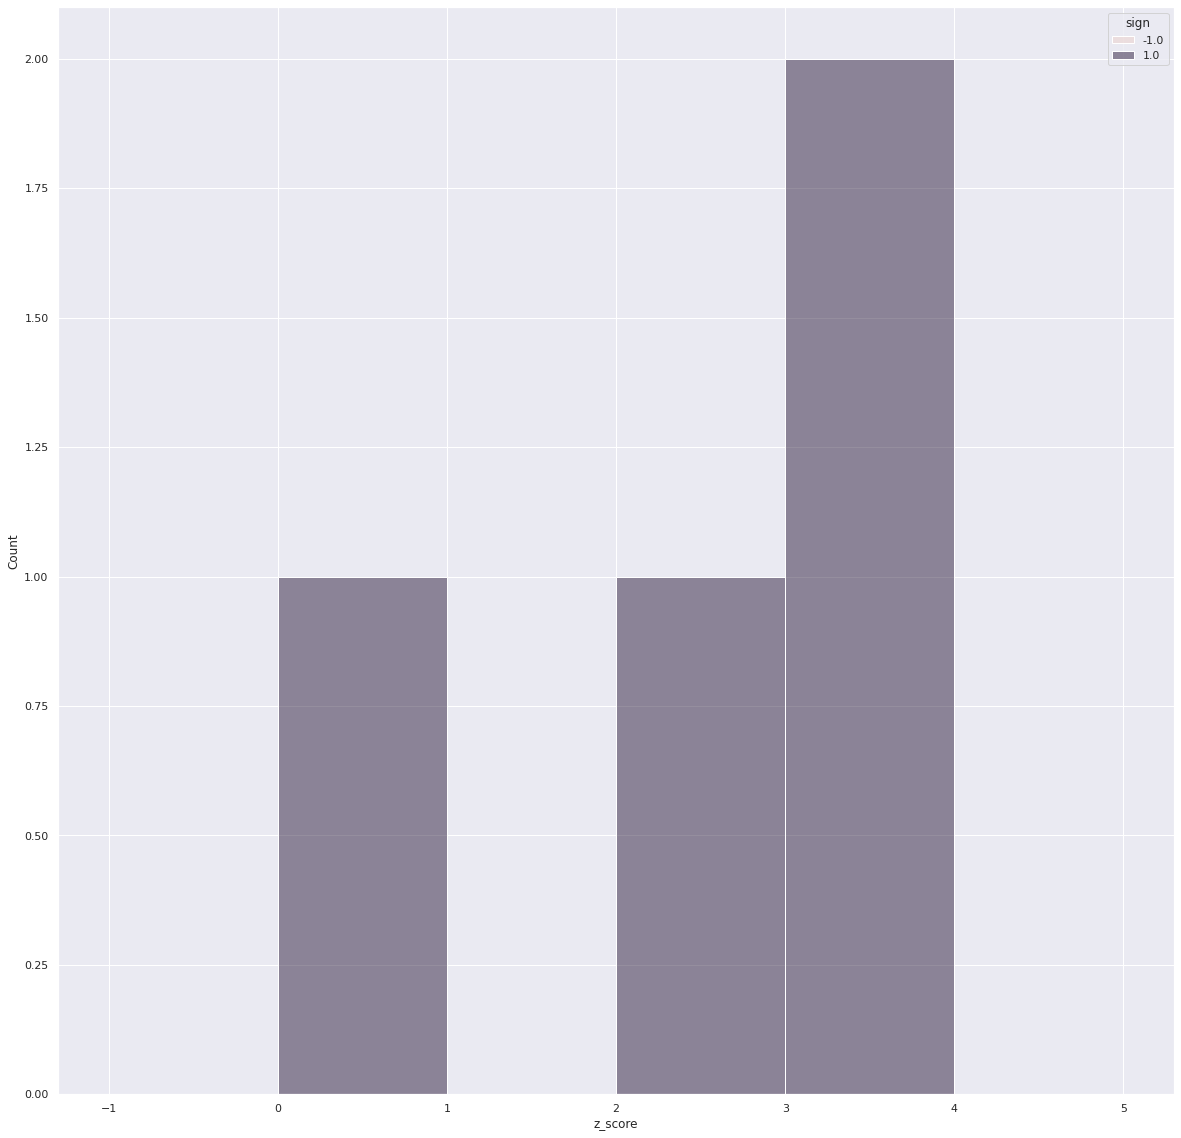

In [105]:
z_test['sign'] = np.sign(z_test.z_score)
hist_z = sns.histplot(data=z_test, x='z_score', hue='sign', bins=[-1,0,1,2,3,4,5])#, bins=[-0.5,-0.1,2,5,10,50,100,200])
# hist_z.set_xscale('log')

In [92]:
z_plot = sns.barplot(data=z_test, x='z', y=z_test.index, hue='model')
z_plot.set_xscale("log")

ValueError: Could not interpret input 'z'

In [19]:
metrics = pd.concat([smag_tree_metrics, smag_lasso_metrics, ag_tree_metrics, ag_lasso_metrics], axis=0, keys=['smag_tree', 'smag_lasso', 'ag_tree', 'ag_lasso'])
metrics['model'] = metrics.index.get_level_values(0)
metrics = metrics.droplevel(level=0)
metrics

Coefficient_of_determination  explained_variance_score  \
visceral_fat_volume                      0.600255                  0.600735   
visceral_fat_volume                      0.629100                  0.629160   
visceral_fat_volume                      0.590880                  0.590911   
visceral_fat_volume                      0.610479                  0.610706   
visceral_fat_volume                      0.619869                  0.619933   
...                                           ...                       ...   
smoke_tobacco_now                             NaN                       NaN   
smoke_tobacco_now                             NaN                       NaN   
smoke_tobacco_now                             NaN                       NaN   
smoke_tobacco_now                             NaN                       NaN   
smoke_tobacco_now                             NaN                       NaN   

                     pearson_r  pearson_p_value  spearman_r  spearman_p_value  \
visceral_fat_volume   0.783143    5.193681e-173    0.810912     6.944424e-195   
visceral_fat_volume   0.795615    1.103661e-185    0.819307     7.526152e-206   
visceral_fat_volume   0.772040    1.737867e-169    0.802281     1.194908e-192   
visceral_fat_volume   0.783932    8.062416e-169    0.806252     1.020253e-185   
visceral_fat_volume   0.790410    2.691987e-186    0.813761     4.609218e-206   
...                        ...              ...         ...               ...   
smoke_tobacco_now          NaN              NaN         NaN               NaN   
smoke_tobacco_now          NaN              NaN         NaN               NaN   
smoke_tobacco_now          NaN              NaN         NaN               NaN   
smoke_tobacco_now          NaN              NaN         NaN               NaN   
smoke_tobacco_now          NaN              NaN         NaN               NaN   

                     prevalence       AUC  Precision_Recall      model  
visceral_fat_volume         NaN       NaN               NaN  smag_tree  
visceral_fat_volume         NaN       NaN               NaN  smag_tree  
visceral_fat_volume         NaN       NaN               NaN  smag_tree  
visceral_fat_volume         NaN       NaN               NaN  smag_tree  
visceral_fat_volume         NaN       NaN               NaN  smag_tree  
...                         ...       ...               ...        ...  
smoke_tobacco_now      0.153104  0.595566          0.184089   ag_lasso  
smoke_tobacco_now      0.159788  0.607534          0.213949   ag_lasso  
smoke_tobacco_now      0.153061  0.656738          0.235673   ag_lasso  
smoke_tobacco_now      0.157134  0.600193          0.208150   ag_lasso  
smoke_tobacco_now      0.153341  0.592243          0.203652   ag_lasso  

[8400 rows x 10 columns]

In [55]:
sns.set_theme()
# sns.set(rc={'axes.facecolor':(0,0,0,0), 'figure.facecolor':(0,0,0,0)})
plt.rcParams['figure.figsize'] = [10, 10]

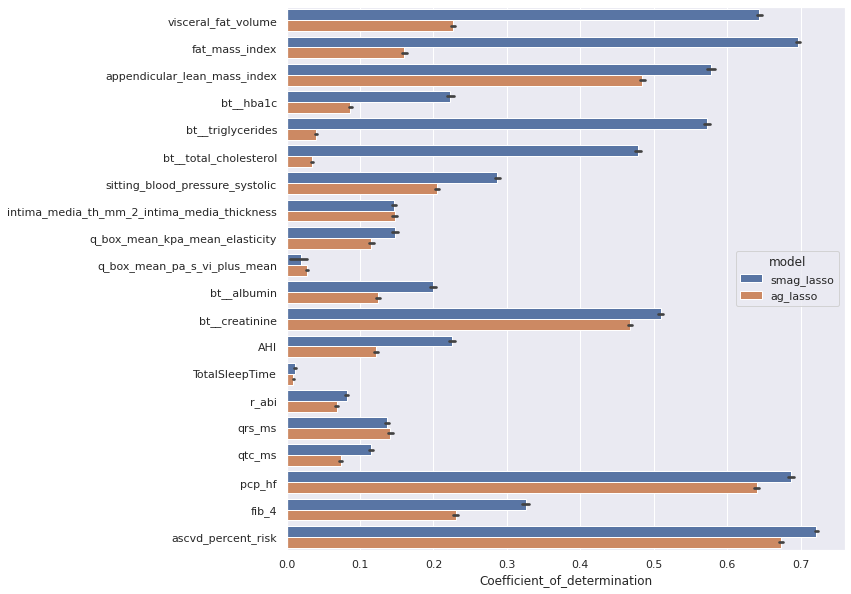

In [21]:
metrics_lasso = pd.concat([smag_lasso_metrics, ag_lasso_metrics], axis=0, keys=['smag_lasso', 'ag_lasso'])
metrics_lasso['model'] = metrics_lasso.index.get_level_values(0)
metrics_lasso = metrics_lasso.droplevel(level=0)
sns.barplot(data=metrics_lasso.drop('smoke_tobacco_now'), x='Coefficient_of_determination', y=metrics_lasso.drop('smoke_tobacco_now').index, hue='model')
plt.savefig(join(ag_smag_plot_path, 'r_2_barplot.png'), bbox_inches='tight')

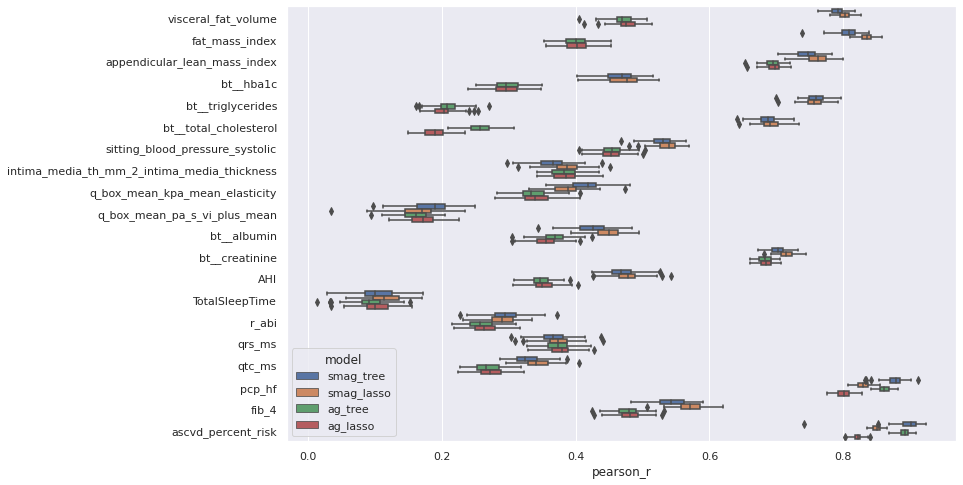

In [206]:

sns.boxplot(data = metrics.drop('smoke_tobacco_now'), x='pearson_r', y=metrics.drop('smoke_tobacco_now').index, hue='model')
plt.savefig(join(ag_smag_plot_path, 'pearson_r_boxplot.png'), bbox_inches='tight')

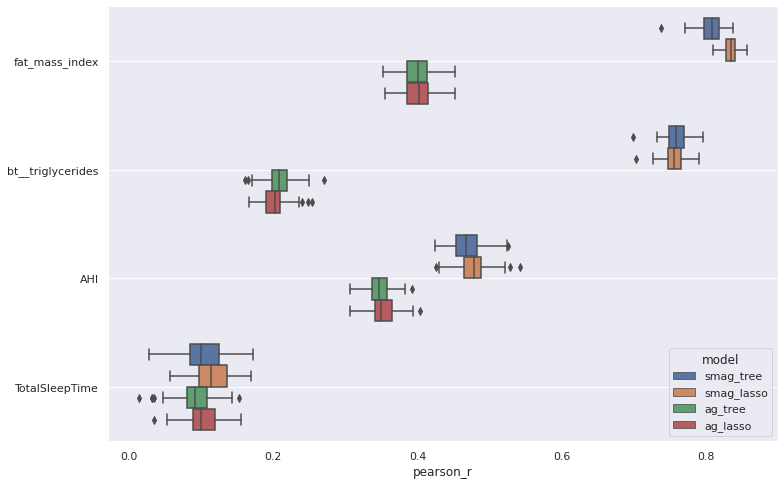

In [27]:
reduced_rs = ['fat_mass_index', 'bt__triglycerides', 'AHI', 'TotalSleepTime']
metrics_reduced = metrics.loc[reduced_rs]
plt.rcParams['figure.figsize'] = [12, 8]
sns.boxplot(data = metrics_reduced, x='pearson_r', y=metrics_reduced.index, hue='model')
plt.grid()

In [207]:
metrics[['model','pearson_r']].groupby([metrics.index, 'model']).mean().to_csv(join(ag_smag_plot_path, 'mean_pearson_r_all_models.csv'))#.loc[('AHI','ag_lasso')]

In [170]:
# ag_results = cl.load_pickle(join(ag_pred_path, 'combined_results.pickle'))
# smag_results = cl.load_pickle(join(smag_pred_path, 'combined_results.pickle'))
sm_results = cl.load_pickle(join(sm_pred_path, 'combined_results.pickle'))

In [1]:
risks = cl.risk_factors + ['gender', 'age']
ag_results= ag_results.loc[risks].drop(['gender','age'], axis=0)
smag_results = smag_results.loc[risks].drop(['gender','age'], axis=0)

NameError: name 'cl' is not defined

In [3]:
def load_from_subfolders(base_path: os.path, path_in_folder: os.path, file_name: str, list_of_folder: list = cl.risk_factors):
    df = pd.DataFrame()
    for folder in list_of_folder:
        tmp_path = join(base_path, folder)
        for file in glob.glob(join(tmp_path, path_in_folder, file_name)):
            df = pd.concat([df, pd.DataFrame(cl.load_pickle(file))], axis=1)

    return df


def average_over_all_iter_models(df):
    import numbers
    return df.groupby(by=df.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])


In [9]:
shap_imp_smag_tree = average_over_all_iter_models(load_from_subfolders(base_path=smag_pred_path, path_in_folder=join('**', tree_str, 'shap'), file_name='5_important_features.pickle'))
shap_imp_smag_lasso = average_over_all_iter_models(load_from_subfolders(base_path=smag_pred_path, path_in_folder=join('**', lasso_str, 'shap'), file_name='5_important_features.pickle'))

# shap_imp_ag_tree = average_over_all_iter_models(load_from_subfolders(base_path=ag_pred_path, path_in_folder=join('**', tree_str, 'shap'), file_name='5_important_features.pickle'))
# shap_imp_ag_lasso = average_over_all_iter_models(load_from_subfolders(base_path=ag_pred_path, path_in_folder=join('**', lasso_str, 'shap'), file_name='5_important_features.pickle'))

In [13]:
len(cl.risk_factors)

21

Text(0.5, 0, '# of risk factors')

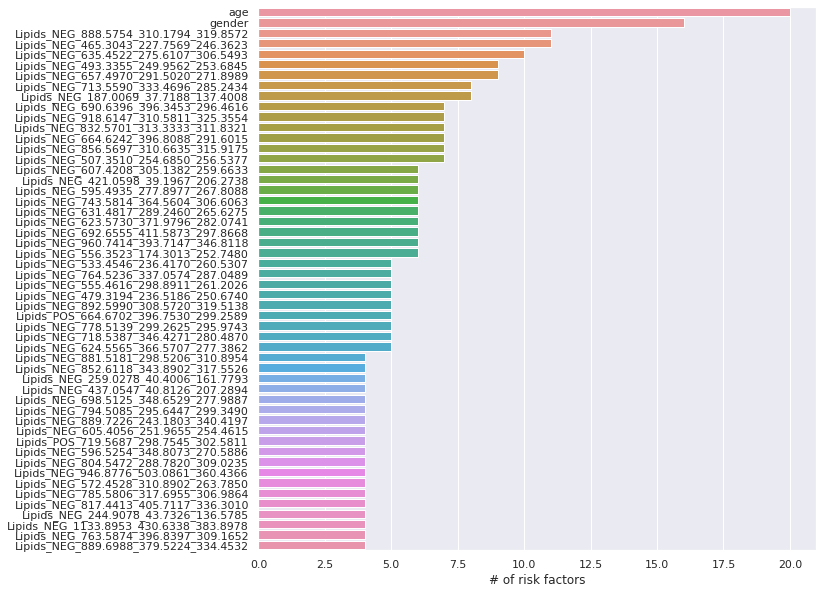

In [12]:
freq_shap = shap_imp_smag_lasso.count(axis=1)
freq_shap = freq_shap[freq_shap>3].sort_values(ascending=False)
sns.barplot(x=freq_shap, y=freq_shap.index)
plt.xlabel('# of risk factors')
# freq_shap

In [ ]:
shap_smag_tree = load_from_subfolders(base_path=smag_pred_path, path_in_folder=join('**', tree_str, 'shap'), file_name='shap_df.pickle')
shap_imp_smag_tree.loc[shap_imp_smag_tree.fillna(shap_smag_tree).index]

In [29]:
models_smag_lasso = cl.load_pickle(join(smag_pred_path,reduced_rs[0], '0','lasso','model.pickle'))

    # load_from_subfolders(base_path=smag_pred_path, path_in_folder=join('**', lasso_str), file_name='model.pickle')
# load_from_subfolders(base_path=smag_pred_path. path_in_folder=join('**', tree_str), file_name='model.pickle')

LassoCV()

In [38]:
pd.DataFrame(data=models_smag_lasso.coef_, index=models_smag_lasso.feature_names_in_).drop_duplicates()

0
age                                    0.014010
Lipids_NEG_213.0551_31.1470_150.8722   0.000000
Lipids_NEG_217.0025_30.9563_142.6050   0.000000
Lipids_NEG_232.9752_30.7462_142.0463  -0.000000
Lipids_NEG_255.8219_33.2194_130.6976   0.000000
...                                         ...
Lipids_POS_502.3728_180.8955_229.8738 -0.000000
Lipids_POS_356.3520_202.2460_210.9004 -0.000000
Lipids_POS_312.3252_207.5235_196.5022 -0.000000
Lipids_POS_458.3466_180.0755_222.7143  0.000000
gender                                -0.248447

[3694 rows x 1 columns]

Text(0.5, 0, '# of risk factors')

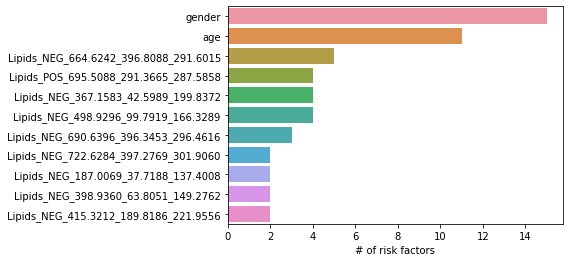

In [10]:
shap_imp_full_train_tree = load_from_subfolders(base_path=smag_pred_path, path_in_folder=join('full_train', tree_str, 'shap'), file_name='5_important_features.pickle')
freq_shap_full = shap_imp_full_train_tree.count(axis=1)
freq_shap_full = freq_shap_full[freq_shap_full>1].sort_values(ascending=False)
sns.barplot(x=freq_shap_full, y=freq_shap_full.index)
plt.xlabel('# of risk factors')

In [4]:
cardio_risks = ['bt__triglycerides', 'bt__total_cholesterol', 'sitting_blood_pressure_systolic',
                'intima_media_th_mm_2_intima_media_thickness', 'r_abi',
                'qrs_ms', 'qtc_ms', 'pcp_hf', 'fib_4', 'ascvd_percent_risk']

y_cardio_pred = load_from_subfolders(
    base_path=smag_pred_path, path_in_folder=join('0', lasso_str), file_name='y_pred.pickle', list_of_folder=cardio_risks)

y_cardio_test = load_from_subfolders(
    base_path=smag_pred_path, path_in_folder=join('0'), file_name='y_test_normalizes.pickle', list_of_folder=cardio_risks)

In [5]:
import Loaders


ag = Loaders.get_SubjectLoader()
bmi = Loaders.get_BodyMeasuresLoaderDF()['bmi'].astype('float')
ag.gender = ag.gender.astype('int')
sm = Loaders.get_SerumMetabolomicsLoader()

In [6]:
smag = pd.concat([ag, sm], axis=1, join='inner')
agb = pd.concat([ag, bmi], axis=1, join='inner')
smagb = pd.concat([agb, sm], axis=1, join='inner')

In [7]:
import RiskScoresPredictors
from sklearn.model_selection import train_test_split

bmi_dir = join(cl.PREDICTION_RISK_SCORE_PATH, 'SerumMetabolomics_Age_Gender')
y_df = pd.DataFrame(bmi.dropna())
x_df = smag

x_df = x_df.reindex(y_df.dropna(how='all').index).dropna(how='all')
y_df = y_df.reindex(x_df.index).dropna(how='all')
x_df = x_df.reindex(y_df.index)
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df)

In [8]:
import RiskScoresPredictors
x_train, x_test, scaler = RiskScoresPredictors.Standardization(x_train, x_test)
y_train, y_test, scaler = RiskScoresPredictors.Standardization(y_train, y_test)

In [9]:
x_train, x_test = RiskScoresPredictors._imputation(x_train, x_test)


In [10]:
import numpy as np
import pandas as pd

from pandas import DataFrame, concat, Series
from sklearn import metrics
from sklearn.linear_model import RidgeCV, LarsCV, LassoCV, ElasticNetCV, LassoLarsCV, RANSACRegressor, HuberRegressor

cl.save_pickle(x_train, join(smag_pred_path, 'bmi'),'x_train.pickle')
cl.save_pickle(x_test, join(smag_pred_path, 'bmi'),'x_test.pickle')

lasso_model = LassoCV().fit(x_train, y_train)
y_pred = DataFrame(lasso_model.predict(x_test).ravel(), index=x_test.index, columns=y_test.columns)

cl.save_pickle(y_pred, join(smag_pred_path, 'bmi'),'y_pred.pickle')
cl.save_pickle(lasso_model, join(smag_pred_path, 'bmi'), 'model.pickle')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.503e-01, tolerance: 3.719e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.594e-01, tolerance: 3.719e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.382e-01, tolerance: 3.719e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e+00, tolerance: 3.719e-01
Objective did not converge. You might want to increase the number of iterations

In [50]:
y_pred_df = pd.DataFrame(y_pred, columns=['bmi_pred'])
y_test_df = pd.DataFrame(y_test, columns=['bmi_test'])
# y_data = pd.concat([y_test_df, y_pred_df], axis=0)
y_data = pd.DataFrame(pd.concat([y_test, y_pred], axis=1))#, columns=['test','pred'])
y_data = y_data.set_axis(['test','pred'], axis=1)
# y_data



In [33]:
cl.save_pickle(y_test, join(smag_pred_path, 'bmi'), 'y_test.pickle')
cl.save_pickle(x_test, join(smag_pred_path, 'bmi'), 'x_test.pickle')
cl.save_pickle(y_train, join(smag_pred_path, 'bmi'), 'y_train.pickle')
cl.save_pickle(x_train, join(smag_pred_path, 'bmi'), 'x_train.pickle')
cl.save_pickle(lasso_model, join(smag_pred_path, 'bmi'), 'model.pickle')

In [54]:
from scipy.stats import pearsonr

pearsonr(y_pred['bmi'], y_test['bmi'])[0]

0.7732711761448045

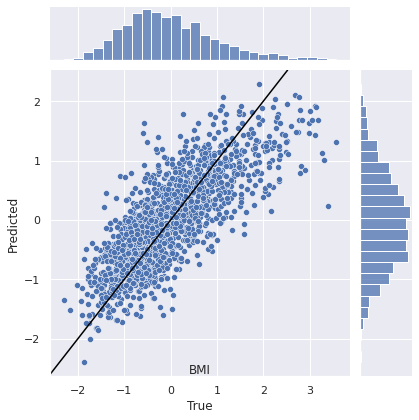

In [56]:
jpb = sns.jointplot(data=y_data, x='test', y='pred')


jpb.set_axis_labels('True', 'Predicted')
jpb.ax_joint.axline([0, 0], [1, 1], color='black', label='Identity')
# g.ax_joint.annotate(
#     f'$tree_\\rho = {metrics_tree.loc[rs].pearson_r[0]:.3f}$  \n $lasso_\\rho = {metrics_lasso.loc[rs].pearson_r[0]:.3f}$',
#     xy=(0.65, 0.25), xycoords='axes fraction',
#     ha='left', va='center',
#     bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
# g.ax_joint.annotate(rs,
#                     xy=(0.4, 0.1), xycoords='axes fraction',
#                     ha='left', va='center')


jpb.ax_joint.set_title('BMI', y=-0.01)

jpb.savefig(join(smag_plot_path, 'ScatterPlots', f'BMI_lasso_scatterplot.png'))

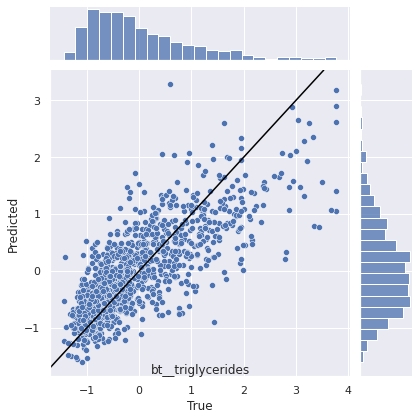

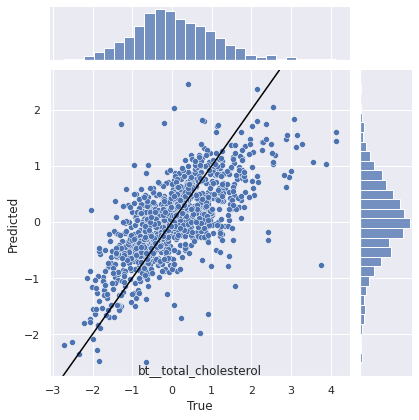

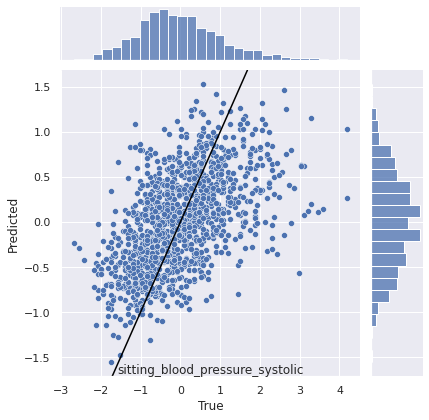

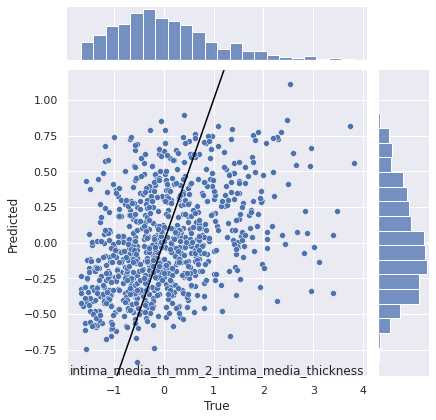

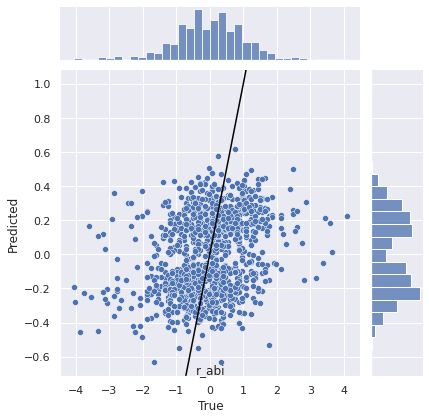

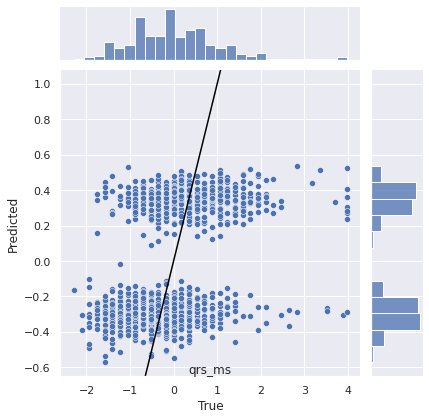

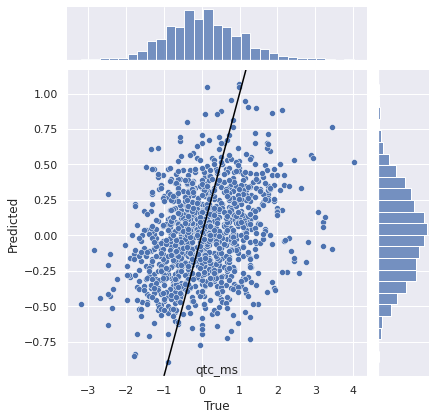

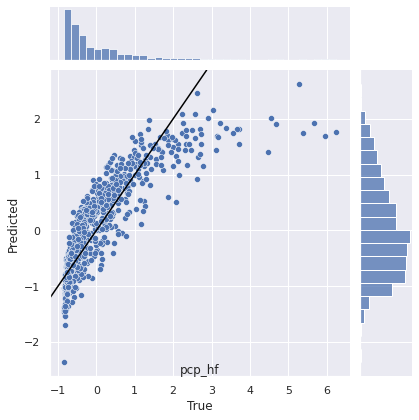

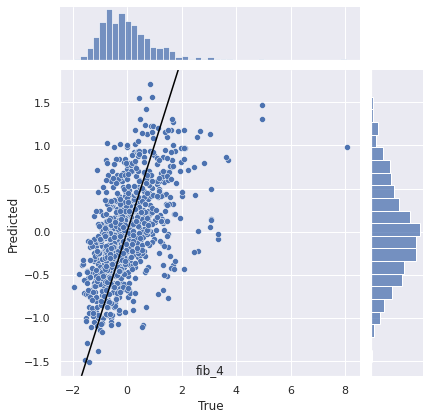

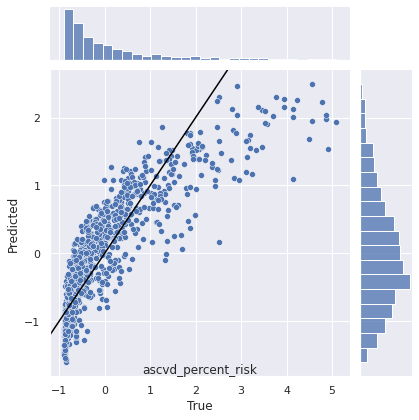

In [34]:
for rs in cardio_risks:

    jp = sns.jointplot(x=y_cardio_test[rs], y=y_cardio_pred[rs])


    jp.set_axis_labels('True', 'Predicted')
    jp.ax_joint.axline([0, 0], [1, 1], color='black', label='Identity')
    # g.ax_joint.annotate(
    #     f'$tree_\\rho = {metrics_tree.loc[rs].pearson_r[0]:.3f}$  \n $lasso_\\rho = {metrics_lasso.loc[rs].pearson_r[0]:.3f}$',
    #     xy=(0.65, 0.25), xycoords='axes fraction',
    #     ha='left', va='center',
    #     bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    # g.ax_joint.annotate(rs,
    #                     xy=(0.4, 0.1), xycoords='axes fraction',
    #                     ha='left', va='center')


    jp.ax_joint.set_title(rs, y=-0.01)

    jp.savefig(join(smag_plot_path, 'ScatterPlots', f'{rs}_lasso_scatterplot.png'))

In [25]:
y_cardio_test

bt__triglycerides  bt__total_cholesterol  \
10K_8210702869          -0.186410               0.055204   
10K_1112370822          -0.141562               0.140181   
10K_8600263730           0.205419              -0.078089   
10K_1132178520           0.004193               0.416357   
10K_2151632867          -0.152774               0.118937   
...                           ...                    ...   
10K_9724407372                NaN                    NaN   
10K_8803223982                NaN                    NaN   
10K_4324578375                NaN                    NaN   
10K_1799738863                NaN                    NaN   
10K_3005192459                NaN                    NaN   

                sitting_blood_pressure_systolic  \
10K_8210702869                        -0.375146   
10K_1112370822                        -0.227236   
10K_8600263730                         0.384874   
10K_1132178520                         0.253469   
10K_2151632867                              NaN   
...                                         ...   
10K_9724407372                              NaN   
10K_8803223982                              NaN   
10K_4324578375                              NaN   
10K_1799738863                              NaN   
10K_3005192459                              NaN   

                intima_media_th_mm_2_intima_media_thickness     r_abi  \
10K_8210702869                                    -0.115594 -0.245834   
10K_1112370822                                     0.082137 -0.210872   
10K_8600263730                                     0.061160  0.266199   
10K_1132178520                                     0.724763 -0.097246   
10K_2151632867                                          NaN       NaN   
...                                                     ...       ...   
10K_9724407372                                          NaN       NaN   
10K_8803223982                                          NaN       NaN   
10K_4324578375                                          NaN       NaN   
10K_1799738863                                          NaN       NaN   
10K_3005192459                                          NaN       NaN   

                  qrs_ms    qtc_ms    pcp_hf     fib_4  ascvd_percent_risk  
10K_8210702869 -0.359120  0.220677 -0.067545       NaN           -0.555372  
10K_1112370822 -0.342491  0.275759  0.332985  0.104828           -0.193469  
10K_8600263730  0.402010 -0.264715       NaN       NaN                 NaN  
10K_1132178520 -0.288447  0.454774  1.634705  0.877590                 NaN  
10K_2151632867 -0.346648  0.261988  0.232852       NaN                 NaN  
...                  ...       ...       ...       ...                 ...  
10K_9724407372       NaN       NaN       NaN -0.014058                 NaN  
10K_8803223982       NaN       NaN       NaN -0.549047                 NaN  
10K_4324578375       NaN       NaN       NaN -0.224547                 NaN  
10K_1799738863       NaN       NaN       NaN -0.430161                 NaN  
10K_3005192459       NaN       NaN       NaN -0.786820                 NaN  

[2229 rows x 10 columns]

## Extracting the different model's metrics

In [7]:
metrics_ag_tree = pd.json_normalize(ag_results.metrics_tree)
metrics_ag_tree.index = ag_results.index
# metrics_ag_tree.pearson_r = metrics_ag_tree.pearson_r.apply(lambda x: x[0])

metrics_ag_lasso = pd.json_normalize(ag_results.metrics_lasso)
metrics_ag_lasso.index = ag_results.index
# metrics_ag_lasso.pearson_r = metrics_ag_lasso.pearson_r.apply(lambda x: x[0])

metrics_smag_tree = pd.json_normalize(smag_results.metrics_tree)
metrics_smag_tree.index = smag_results.index
# metrics_smag_tree.pearson_r = metrics_smag_tree.pearson_r.apply(lambda x: x[0])

metrics_smag_lasso = pd.json_normalize(smag_results.metrics_lasso)
metrics_smag_lasso.index = smag_results.index
# metrics_smag_lasso.pearson_r = metrics_smag_lasso.pearson_r.apply(lambda x: x[0])


metrics = pd.concat([metrics_ag_lasso, metrics_ag_tree, metrics_smag_lasso, metrics_smag_tree],
                    axis=0, keys=['ag_lasso', 'ag_tree', 'smag_lasso', 'smag_tree'])
metrics['model'] = metrics.index.get_level_values(0)
metrics = metrics.droplevel(level=0)


metrics_diff = pd.DataFrame()
metrics_diff[tree_str] = metrics_smag_tree.pearson_r - metrics_ag_tree.pearson_r
metrics_diff[lasso_str] = metrics_smag_lasso.pearson_r - metrics_ag_lasso.pearson_r
metrics_diff = pd.concat([
    pd.DataFrame.from_dict({'pearson_r': metrics_diff[tree_str], 'model':tree_str}),
    pd.DataFrame.from_dict({'pearson_r': metrics_diff[lasso_str], 'model':lasso_str})])



NameError: name 'smag_results' is not defined

## Extracting Datasets from the results

In [12]:
ag_x_test = ag_results.x_test
smag_x_test = smag_results.x_test
ag_y_test = ag_results.y_test
smag_y_test = smag_results.y_test
ag_y_pred = pd.concat([ag_results.y_pred_tree, ag_results.y_pred_lasso], axis=1)
smag_y_pred = pd.concat([smag_results.y_pred_tree, smag_results.y_pred_lasso], axis=1)

# smag_y_pred = pd.DataFrame(columns=smag_y_pred_tmp.columns)
# ag_y_pred = pd.DataFrame(columns=ag_y_pred_tmp.columns)

# for rs in ag_results.index:
#     smag_y_pred.y_pred_tree = pd.concat([smag_y_pred, pd.DataFrame(
#         smag_y_pred.y_pred_tree.loc[rs], index = smag_y_test.loc[rs].index, columns=smag_y_test.loc[rs].columns)], axis=0)

    # ag_y_pred.y_pred_tree.loc[rs] = pd.DataFrame(
    #     ag_y_pred.y_pred_tree.loc[rs], index = ag_y_test.loc[rs].index, columns=ag_y_test.loc[rs].columns)
    #
    # smag_y_pred.y_pred_lasso.loc[rs] = pd.DataFrame(
    #     smag_y_pred.y_pred_lasso.loc[rs], index = smag_y_test.loc[rs].index, columns=smag_y_test.loc[rs].columns)
    #
    # ag_y_pred.y_pred_lasso.loc[rs] = pd.DataFrame(
    #     ag_y_pred.y_pred_lasso.loc[rs], index = ag_y_test.loc[rs].index, columns=ag_y_test.loc[rs].columns)



In [8]:
sns.set_theme()
# sns.set(rc={'axes.facecolor':(0,0,0,0), 'figure.facecolor':(0,0,0,0)})
plt.rcParams['figure.figsize'] = [15, 15]

## Pearson_r comparison for both LGBM and LassoCV

In [68]:
bs = pd.DataFrame()
bs_ag = pd.DataFrame()

for rs in smag_y_test.index:
    x_tmp = smag_y_test[rs]
    y_l_tmp = smag_y_pred.loc[rs]['y_pred_lasso']
    y_t_tmp = smag_y_pred.loc[rs]['y_pred_tree']
    bs_l = bootstrap((x_tmp, y_l_tmp), lambda x_tmp, y_l_tmp : pearsonr(x_tmp, y_l_tmp)[0], vectorized=False, paired=True).confidence_interval
    bs_t = bootstrap((x_tmp, y_t_tmp), lambda x_tmp, y_t_tmp : pearsonr(x_tmp, y_t_tmp)[0], vectorized=False, paired=True).confidence_interval
    bs.loc[rs, 'low_lasso'] = bs_l[0]
    bs.loc[rs, 'high_lasso'] = bs_l[1]
    bs.loc[rs, 'low_tree'] = bs_t[0]
    bs.loc[rs, 'high_tree'] = bs_t[1]

    metrics[metrics.model=='smag_lasso'].pearson_r = metrics[metrics.model=='smag_lasso'].pearson_r - bs_l[0]
    metrics[metrics.model=='smag_tree'].pearson_r = metrics[metrics.model=='smag_tree'].pearson_r - bs_t[0]


    x_tmp_ag = ag_y_test[rs]
    y_l_tmp_ag = ag_y_pred.loc[rs]['y_pred_lasso']
    y_t_tmp_ag = ag_y_pred.loc[rs]['y_pred_tree']
    bs_l_ag = bootstrap((x_tmp_ag, y_l_tmp_ag), lambda x_tmp_ag, y_l_tmp_ag : pearsonr(x_tmp_ag, y_l_tmp_ag)[0], vectorized=False, paired=True).confidence_interval
    bs_t_ag = bootstrap((x_tmp_ag, y_t_tmp_ag), lambda x_tmp_ag, y_t_tmp_ag : pearsonr(x_tmp_ag, y_t_tmp_ag)[0], vectorized=False, paired=True).confidence_interval
    bs_ag.loc[rs, 'low_lasso'] = bs_l_ag[0]
    bs_ag.loc[rs, 'high_lasso'] = bs_l_ag[1]
    bs_ag.loc[rs, 'low_tree'] = bs_t_ag[0]
    bs_ag.loc[rs, 'high_tree'] = bs_t_ag[1]

    metrics[metrics.model=='ag_lasso'].pearson_r = metrics[metrics.model=='ag_lasso'].pearson_r + bs_l_ag[1]
    metrics[metrics.model=='ag_tree'].pearson_r = metrics[metrics.model=='ag_tree'].pearson_r + bs_t_ag[1]


bs
# x_tmp = smag_y_test[0]
# y_tmp = smag_y_pred.y_pred_lasso[0]
# bs = bootstrap((x_tmp, y_tmp), lambda x_tmp, y_tmp : pearsonr(x_tmp, y_tmp)[0], vectorized=False, paired=True)
# print(bs)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


low_lasso  high_lasso  low_tree  \
visceral_fat_volume                           0.774398    0.820283  0.743000   
fat_mass_index                                0.811709    0.856237  0.774097   
appendicular_lean_mass_index                  0.777817    0.829864  0.747040   
bt__hba1c                                     0.457429    0.573665  0.465068   
bt__triglycerides                             0.722954    0.789207  0.729623   
bt__total_cholesterol                         0.668918    0.738353  0.666146   
sitting_blood_pressure_systolic               0.498505    0.579007  0.487525   
intima_media_th_mm_2_intima_media_thickness   0.317032    0.445892  0.266443   
q_box_mean_kpa_mean_elasticity                0.300052    0.418412  0.337784   
q_box_mean_pa_s_vi_plus_mean                  0.080570    0.216276  0.115964   
bt__albumin                                   0.376048    0.481538  0.345103   
bt__creatinine                                0.694419    0.748327  0.688021   
AHI                                           0.492863    0.579942  0.476801   
TotalSleepTime                                0.049589    0.186112 -0.017220   
r_abi                                         0.244387    0.362575  0.262984   
qrs_ms                                        0.289071    0.394885  0.286344   
qtc_ms                                        0.319337    0.420969  0.292867   
pcp_hf                                        0.814966    0.861592  0.851763   
fib_4                                         0.517418    0.617528  0.493775   
ascvd_percent_risk                            0.835025    0.869836  0.863905   

                                             high_tree  
visceral_fat_volume                           0.804674  
fat_mass_index                                0.826579  
appendicular_lean_mass_index                  0.803406  
bt__hba1c                                     0.583091  
bt__triglycerides                             0.797026  
bt__total_cholesterol                         0.735596  
sitting_blood_pressure_systolic               0.570877  
intima_media_th_mm_2_intima_media_thickness   0.399780  
q_box_mean_kpa_mean_elasticity                0.463800  
q_box_mean_pa_s_vi_plus_mean                  0.253772  
bt__albumin                                   0.454491  
bt__creatinine                                0.742567  
AHI                                           0.570458  
TotalSleepTime                                0.123423  
r_abi                                         0.385798  
qrs_ms                                        0.390094  
qtc_ms                                        0.400156  
pcp_hf                                        0.888162  
fib_4                                         0.602964  
ascvd_percent_risk                            0.898153

In [76]:
bs_all = pd.concat([
    pd.DataFrame.from_dict({'pearson_r': bs_ag.high_lasso, 'model':'ag_high_lasso'}),
    pd.DataFrame.from_dict({'pearson_r': bs_ag.high_tree, 'model':'ag_high_tree'}),
    pd.DataFrame.from_dict({'pearson_r': bs.low_lasso, 'model':'smag_low_lasso'}),
    pd.DataFrame.from_dict({'pearson_r': bs.low_tree, 'model':'smag_low_tree'})
    ])

bs_all

pearson_r          model
visceral_fat_volume            0.559995  ag_high_lasso
fat_mass_index                 0.446015  ag_high_lasso
appendicular_lean_mass_index   0.755933  ag_high_lasso
bt__hba1c                      0.391491  ag_high_lasso
bt__triglycerides              0.214831  ag_high_lasso
...                                 ...            ...
qrs_ms                         0.286344  smag_low_tree
qtc_ms                         0.292867  smag_low_tree
pcp_hf                         0.851763  smag_low_tree
fib_4                          0.493775  smag_low_tree
ascvd_percent_risk             0.863905  smag_low_tree

[80 rows x 2 columns]

<AxesSubplot:xlabel='pearson_r'>

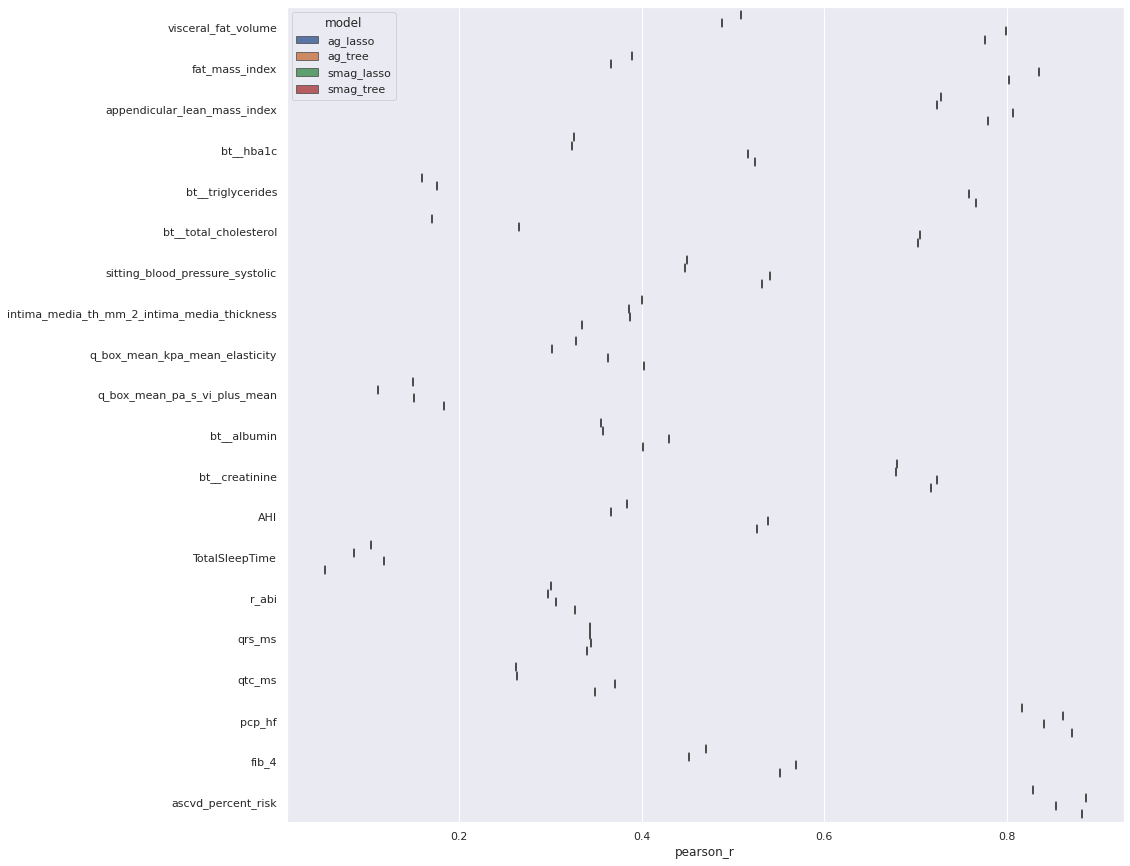

In [50]:
# sns.pointplot(x=metrics.loc['visceral_fat_volume'].pearson_r, y=metrics.loc['visceral_fat_volume'].index, hue=metrics.loc['visceral_fat_volume'].model, errorbar=(0.5, 0.9))
sns.boxplot(x=metrics.pearson_r, y=metrics.index, hue=metrics.model)#, join=False, dodge=2.5, errorbar=(0.5,0.9))

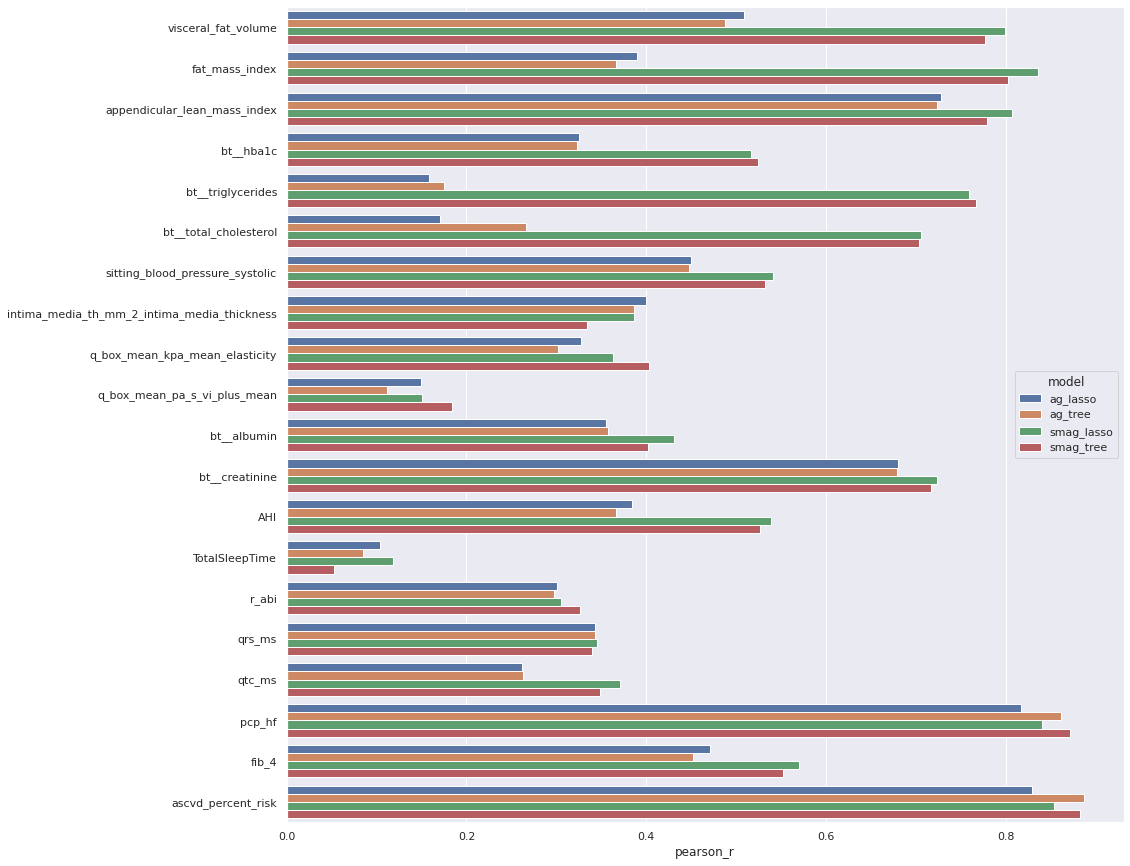

In [13]:

# pearson_data = pd.concat([pearson_tree, pearson_lasso], axis=0, keys=['tree', 'lasso'])
# pearson_data = pd.concat([pearson_data, pearson_data.index.to_frame(name=['model', 'RiskScore'])], axis=1)

pearson_bar_plot = sns.barplot(x=metrics.pearson_r, y=metrics.index, hue=metrics.model)

# plt.savefig(join(ag_smag_plot_path,'pearson_r_barplots.png'), bbox_inches='tight')

<AxesSubplot:xlabel='pearson_r'>

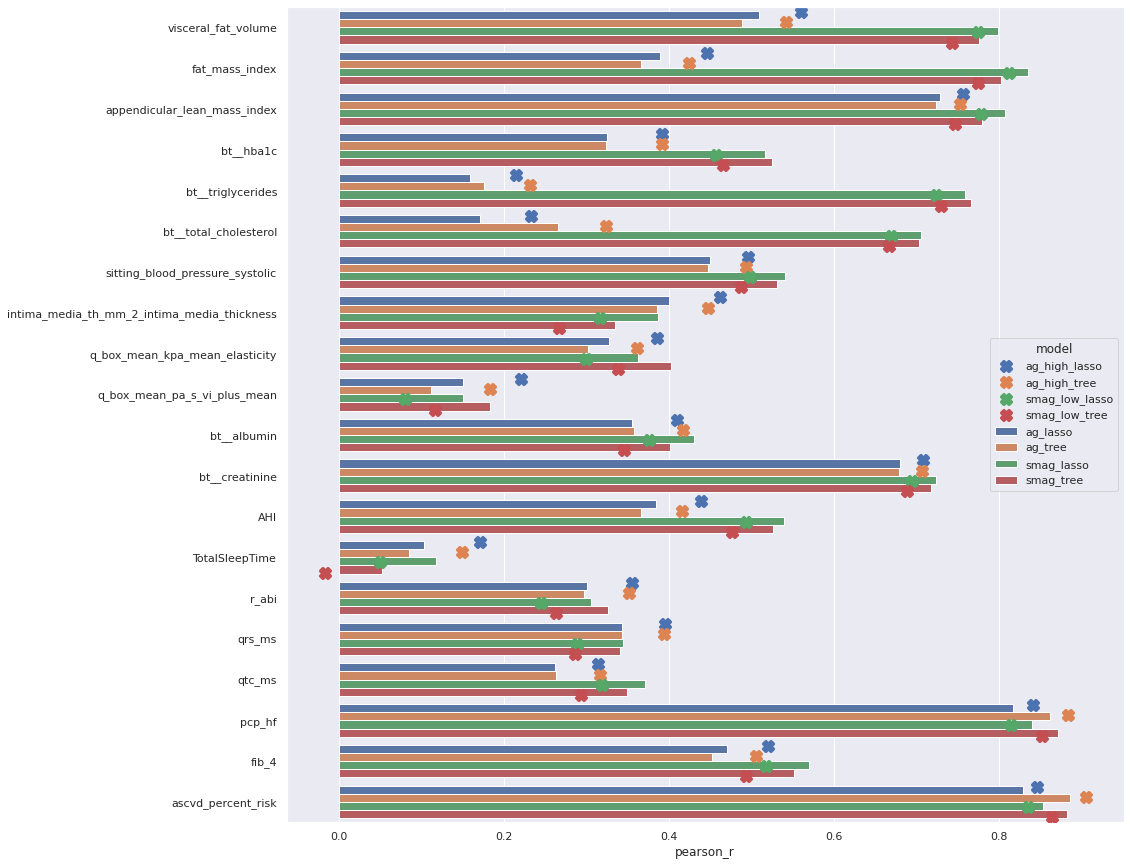

In [93]:
fig, ax = plt.subplots()
sns.barplot(x=metrics.pearson_r, y=metrics.index, hue=metrics.model, ax=ax)
sns.pointplot(x=bs_all.pearson_r, y=bs_all.index, hue=bs_all.model, ax=ax, join=False, dodge=.75, markers='X', scale=1.5)

In [102]:
bs_diff = pd.concat([
    pd.DataFrame.from_dict({'pearson_r': (bs_all[bs_all.model=='smag_low_tree'].pearson_r - bs_all[bs_all.model=='ag_high_tree'].pearson_r), 'model':'tree'}),
    pd.DataFrame.from_dict({'pearson_r': (bs_all[bs_all.model=='smag_low_lasso'].pearson_r - bs_all[bs_all.model=='ag_high_lasso'].pearson_r), 'model': 'lasso'})
    ])
    # pd.DataFrame.from_dict({'pearson_r': (bs_all[bs_all.model=='smag_low_tree'].pearson_r - bs_all[bs_all.model=='ag_high_tree'].pearson_r), 'model':'tree'}),
    # pd.DataFrame.from_dict({(bs_all[bs_all.model=='smag_low_lasso'].pearson_r - bs_all[bs_all.model=='ag_high_lasso'].pearson_r), 'model':'lasso'})], axis=1)
bs_diff

pearson_r  model
visceral_fat_volume                           0.201058   tree
fat_mass_index                                0.350300   tree
appendicular_lean_mass_index                 -0.005312   tree
bt__hba1c                                     0.073654   tree
bt__triglycerides                             0.497537   tree
bt__total_cholesterol                         0.342297   tree
sitting_blood_pressure_systolic              -0.006120   tree
intima_media_th_mm_2_intima_media_thickness  -0.180644   tree
q_box_mean_kpa_mean_elasticity               -0.023459   tree
q_box_mean_pa_s_vi_plus_mean                 -0.067205   tree
bt__albumin                                  -0.072133   tree
bt__creatinine                               -0.018136   tree
AHI                                           0.060722   tree
TotalSleepTime                               -0.166744   tree
r_abi                                        -0.088428   tree
qrs_ms                                       -0.107456   tree
qtc_ms                                       -0.023837   tree
pcp_hf                                       -0.031878   tree
fib_4                                        -0.011538   tree
ascvd_percent_risk                           -0.040799   tree
visceral_fat_volume                           0.214403  lasso
fat_mass_index                                0.365694  lasso
appendicular_lean_mass_index                  0.021884  lasso
bt__hba1c                                     0.065938  lasso
bt__triglycerides                             0.508123  lasso
bt__total_cholesterol                         0.436463  lasso
sitting_blood_pressure_systolic               0.002261  lasso
intima_media_th_mm_2_intima_media_thickness  -0.144230  lasso
q_box_mean_kpa_mean_elasticity               -0.085561  lasso
q_box_mean_pa_s_vi_plus_mean                 -0.140137  lasso
bt__albumin                                  -0.034201  lasso
bt__creatinine                               -0.013317  lasso
AHI                                           0.054534  lasso
TotalSleepTime                               -0.120954  lasso
r_abi                                        -0.111008  lasso
qrs_ms                                       -0.106132  lasso
qtc_ms                                        0.005393  lasso
pcp_hf                                       -0.026225  lasso
fib_4                                        -0.002847  lasso
ascvd_percent_risk                           -0.010646  lasso

<AxesSubplot:xlabel='pearson_r'>

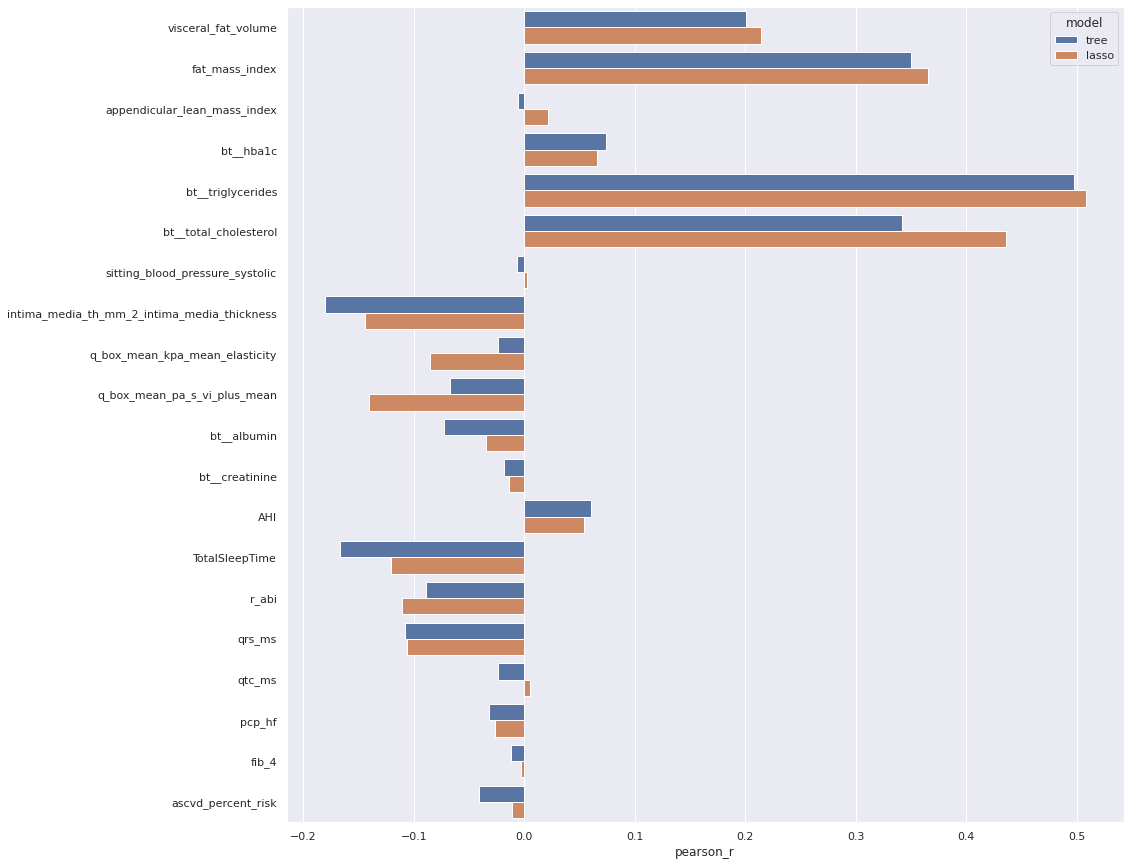

In [103]:
sns.barplot(data=bs_diff, x='pearson_r', y=bs_diff.index, hue='model')

## ROC Curves

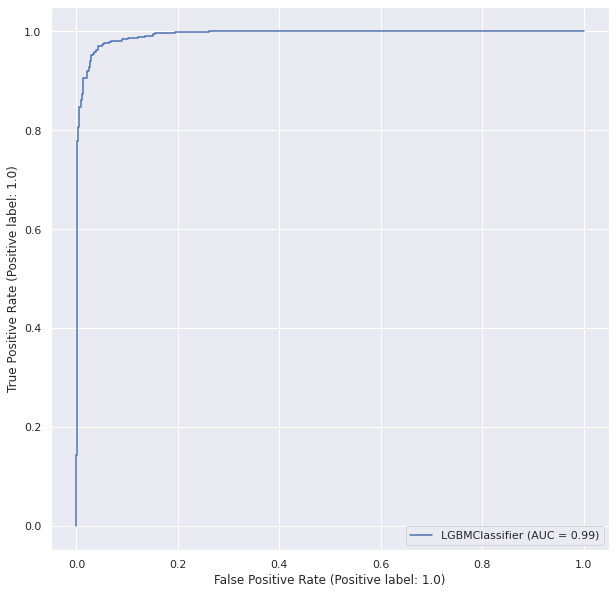

In [173]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(sm_results.loc['gender','model_tree'], sm_results.loc['gender','x_test'], sm_results.loc['gender','y_test'])

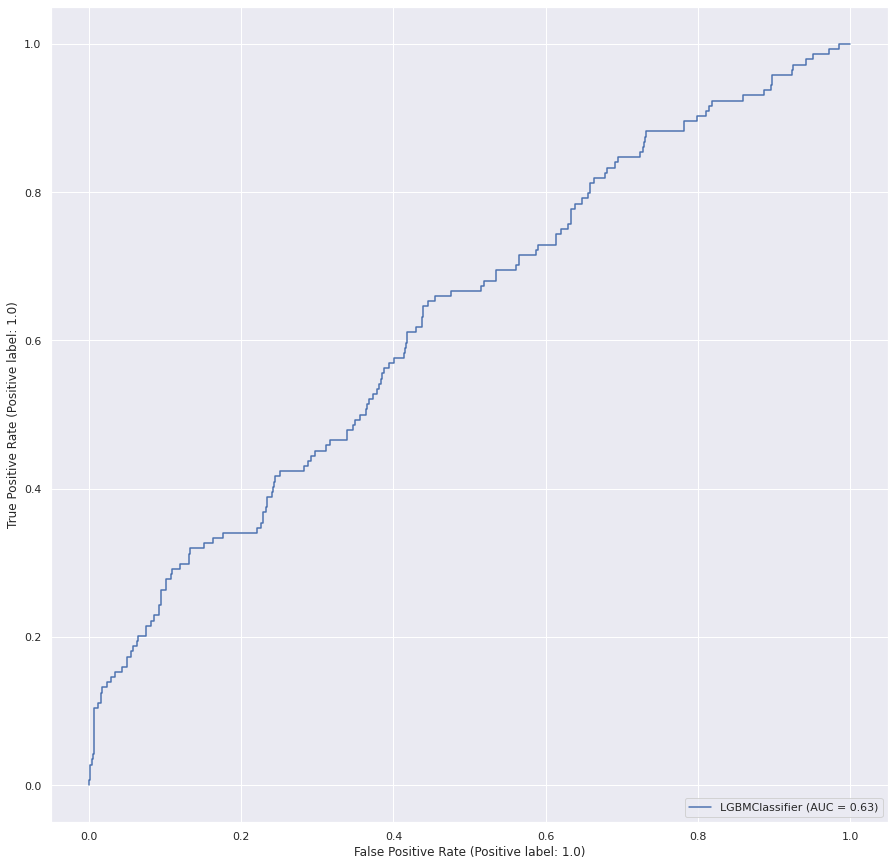

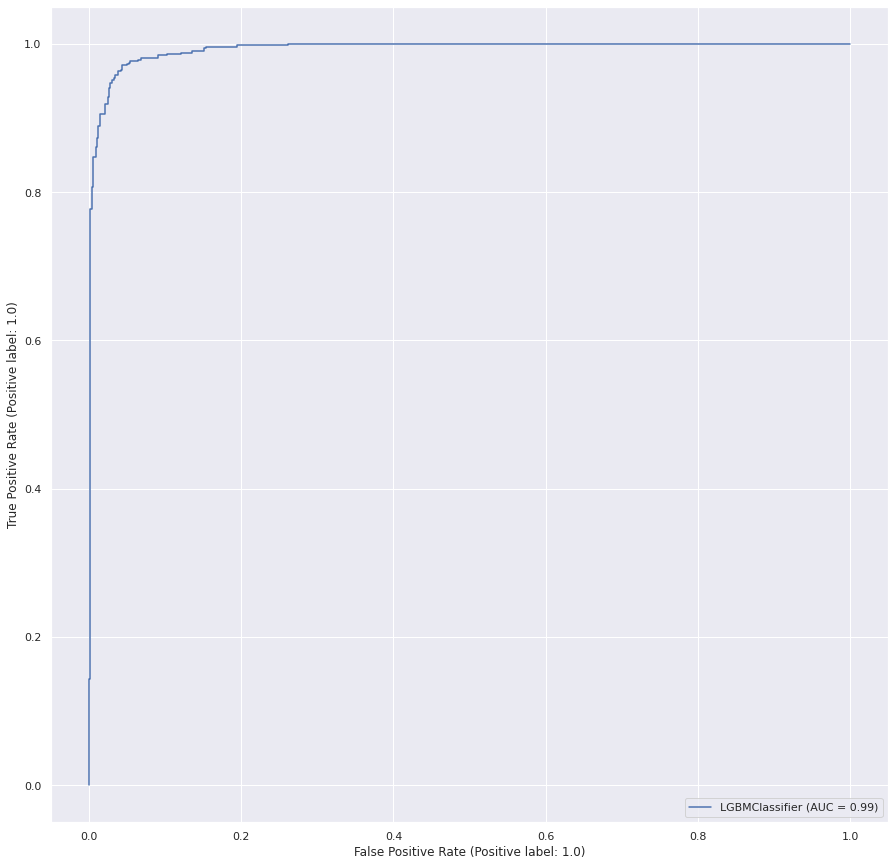

In [66]:
from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(smag_results.loc['smoke_tobacco_now','model_tree'], smag_results.loc['smoke_tobacco_now','x_test'], smag_results.loc['smoke_tobacco_now','y_test'])

RocCurveDisplay.from_estimator(sm_results.loc['gender','model_tree'], sm_results.loc['gender','x_test'], sm_results.loc['gender','y_test'])

## Difference of pearson_r between models

Text(0.5, 1.0, 'SerumMetabolomics_Age_Gender - Age_Gender pearson_r')

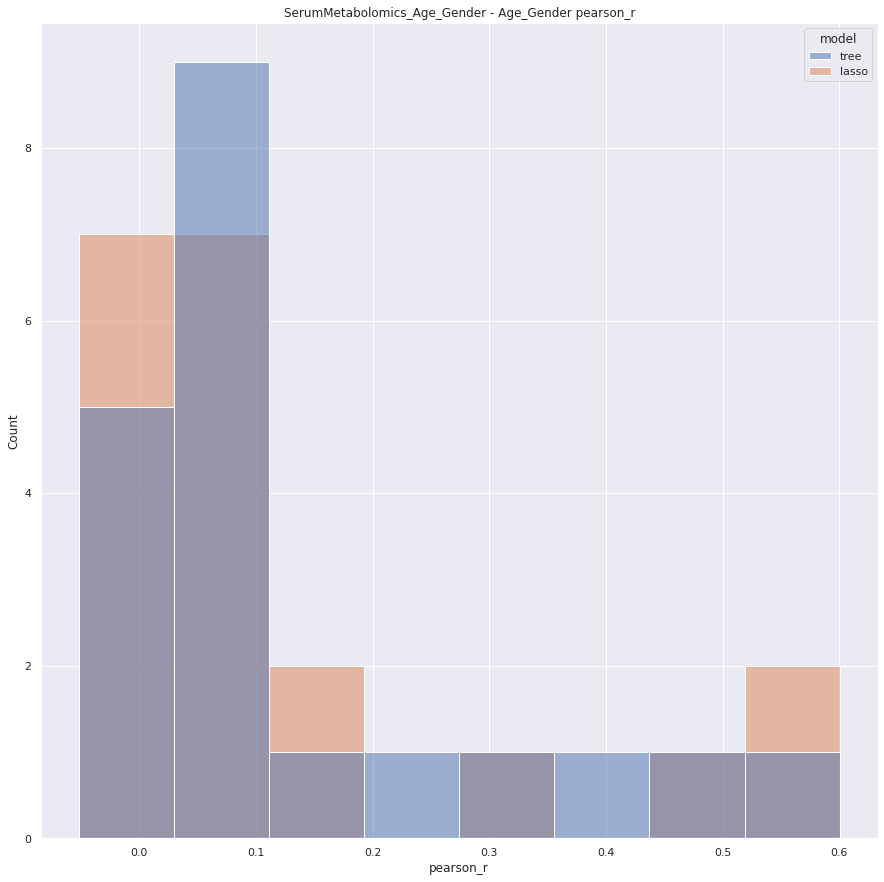

In [14]:
metrics_diff = pd.DataFrame()
metrics_diff[tree_str] = metrics_smag_tree.pearson_r - metrics_ag_tree.pearson_r
metrics_diff[lasso_str] = metrics_smag_lasso.pearson_r - metrics_ag_lasso.pearson_r
metrics_diff = pd.concat([
    pd.DataFrame.from_dict({'pearson_r': metrics_diff[tree_str], 'model':tree_str}),
    pd.DataFrame.from_dict({'pearson_r': metrics_diff[lasso_str], 'model':lasso_str})])

hp = sns.histplot(data=metrics_diff, x='pearson_r', hue='model')
hp.set_title(f'{smag} - {ag} pearson_r')

# plt.savefig(join(ag_smag_plot_path,'pearson_r_difference_histplot.png'), bbox_inches='tight')

In [22]:
metrics_smag_lasso.pearson_r - metrics_ag_lasso.pearson_r

r_abi                                         -0.020909
bt__hba1c                                      0.153390
lean_mass_index                                0.079743
appendicular_lean_mass                         0.050984
appendicular_lean_mass_index                   0.079499
intima_media_th_mm_2_intima_media_thickness   -0.043024
intima_media_th_mm_1_intima_media_thickness   -0.029551
q_box_mean_kpa_mean_elasticity                 0.070426
q_box_mean_pa_s_vi_plus_mean                   0.036993
AHI                                            0.131563
fib_4                                          0.116517
qrs_ms                                        -0.010496
qtc_ms                                         0.085930
visceral_fat_mass                              0.313745
visceral_fat_volume                            0.313745
visceral_fat_area                              0.336623
waist_to_hip_ratio                             0.137220
fat_mass_index                                 0

## Scatter Plots of test vs predicted outcomes

In [15]:
all_data = {}
for rs in smag_results.index.to_list():

    model ={
        0: 'ag_lasso',
        1: 'ag_tree',
        2: 'smag_lasso',
        3: 'smag_tree'
    }

    y_test = pd.concat([ag_y_test.loc[rs], ag_y_test.loc[rs], smag_y_test.loc[rs],smag_y_test.loc[rs]], axis=0, keys=model.keys())#['ag_lasso', 'ag_tree', 'smag_lasso', 'smag_tree'])
    y_test.columns = ['y_test']
    y_test['model'] = y_test.index.get_level_values(0)
    y_test = y_test.droplevel(level=0)

    ag_pred_tree_tmp = ag_y_pred.loc[rs].y_pred_tree
    ag_pred_lasso_tmp = ag_y_pred.loc[rs].y_pred_lasso
    smag_pred_tree_tmp = smag_y_pred.loc[rs].y_pred_tree
    smag_pred_lasso_tmp = smag_y_pred.loc[rs].y_pred_lasso

    ag_pred_tree = pd.DataFrame(ag_pred_tree_tmp, index=ag_y_test.loc[rs].index, columns=[rs])
    ag_pred_lasso = pd.DataFrame(ag_pred_lasso_tmp, index=ag_y_test.loc[rs].index, columns=[rs])
    smag_pred_tree = pd.DataFrame(smag_pred_tree_tmp, index=smag_y_test.loc[rs].index, columns=[rs])
    smag_pred_lasso = pd.DataFrame(smag_pred_lasso_tmp, index=smag_y_test.loc[rs].index, columns=[rs])

    y_pred = pd.concat([ag_pred_lasso, ag_pred_tree, smag_pred_lasso, smag_pred_tree],axis=0, keys=model.keys())#['ag_lasso', 'ag_tree', 'smag_lasso', 'smag_tree'])
    y_pred.columns = ['y_pred']
    y_pred['model'] = y_pred.index.get_level_values(0)
    y_pred = y_pred.droplevel(level=0)

    data = pd.concat([y_test, y_pred], axis=1)
    data = data.T.drop_duplicates().T
    data.model = pd.Categorical(data.model)

    data['Residuals'] = data.y_pred - data.y_test

    all_data[rs] = data

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


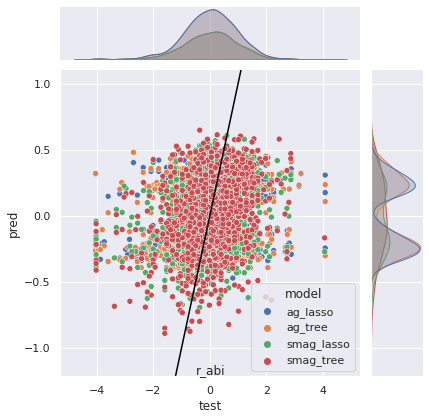

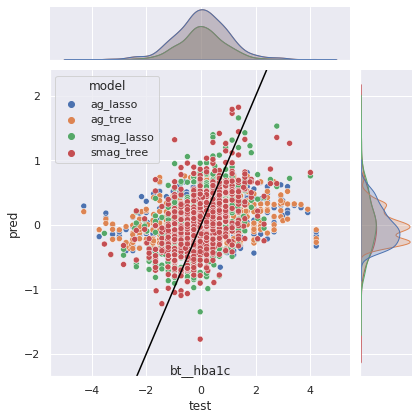

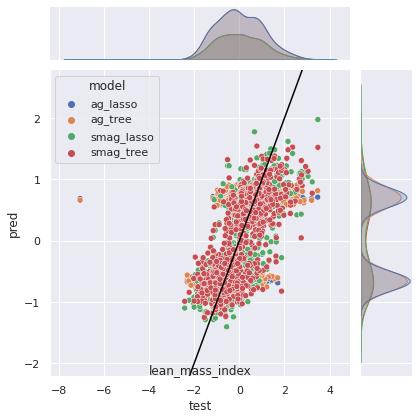

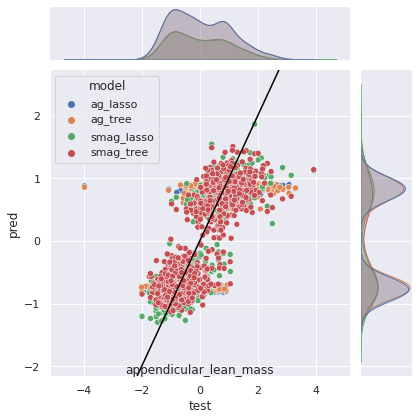

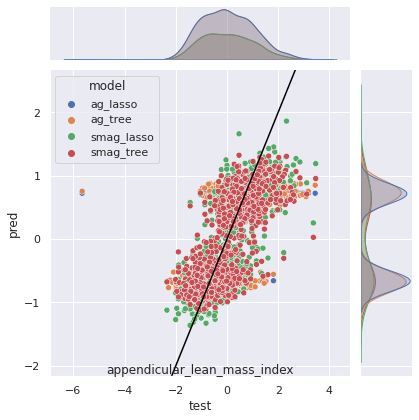

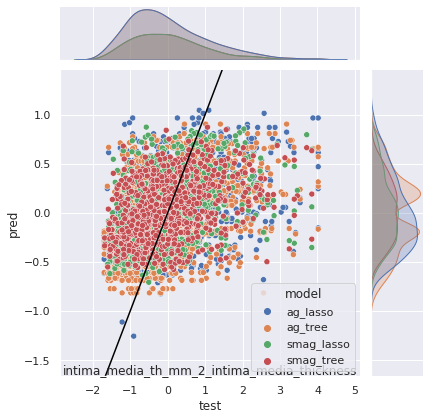

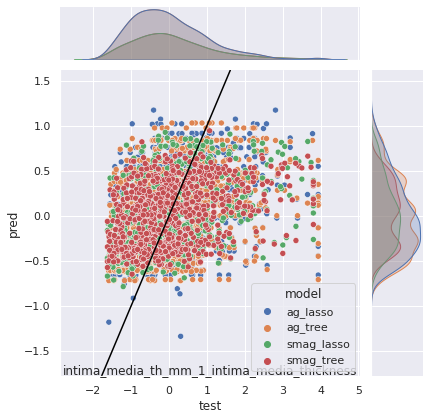

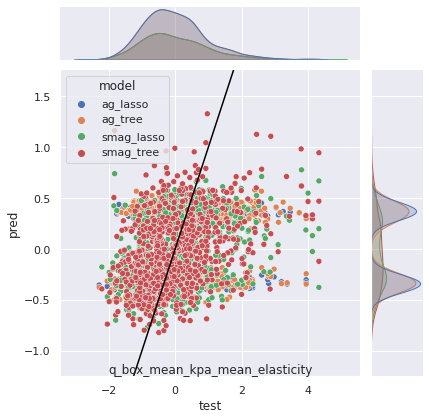

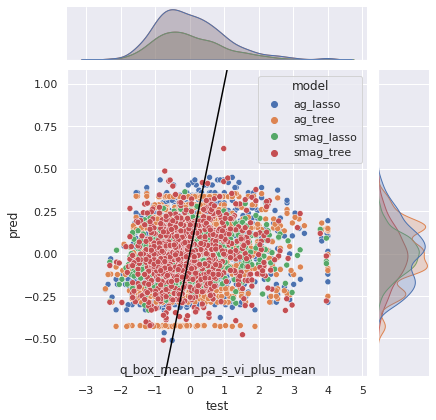

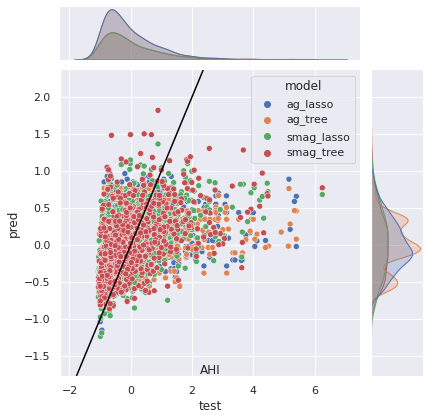

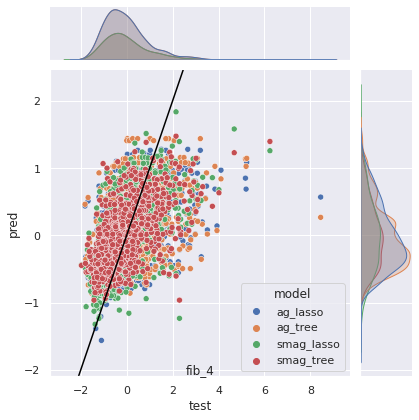

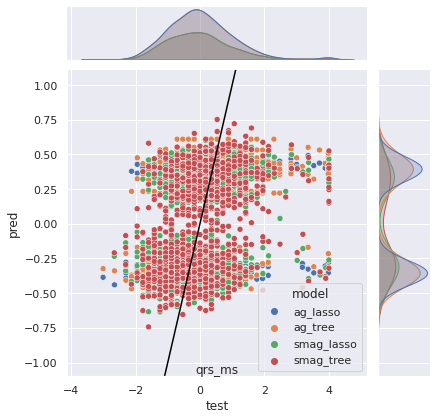

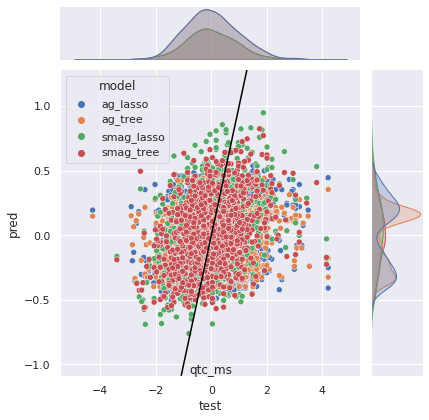

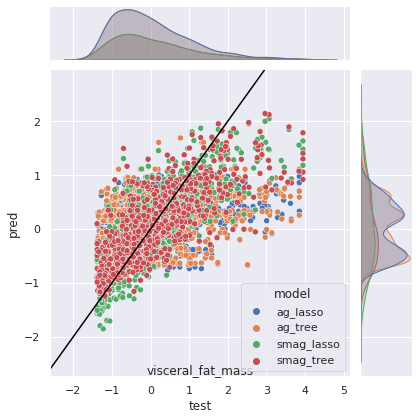

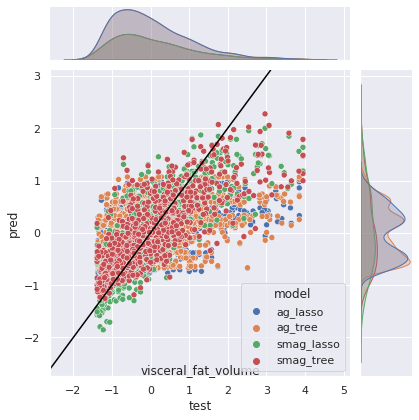

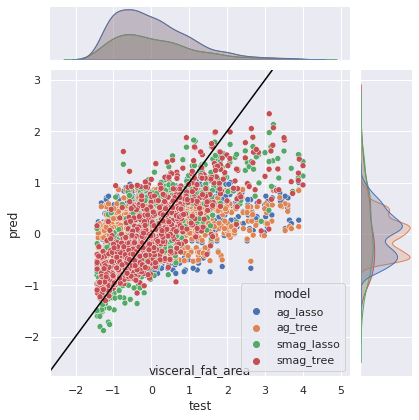

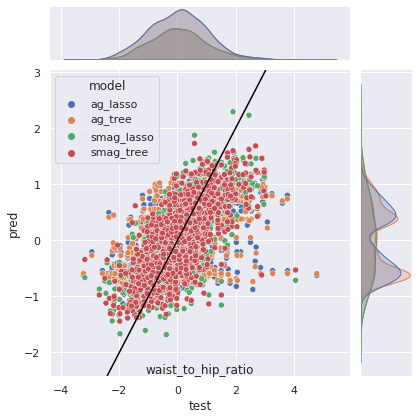

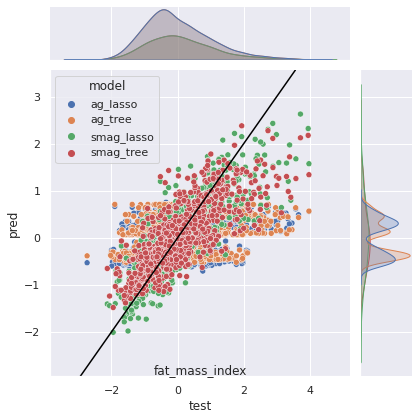

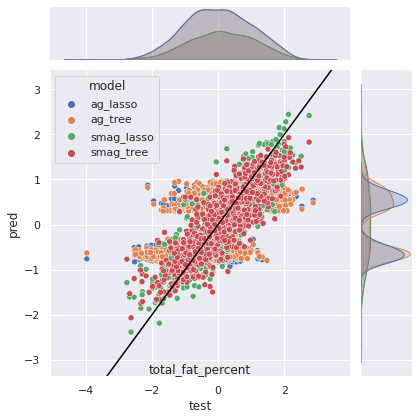

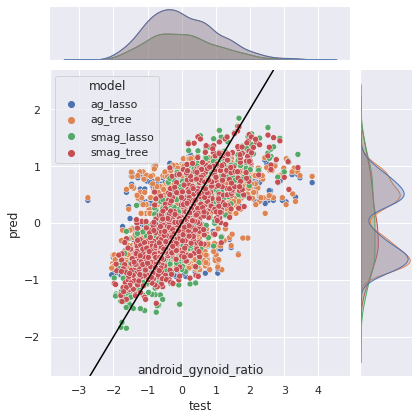

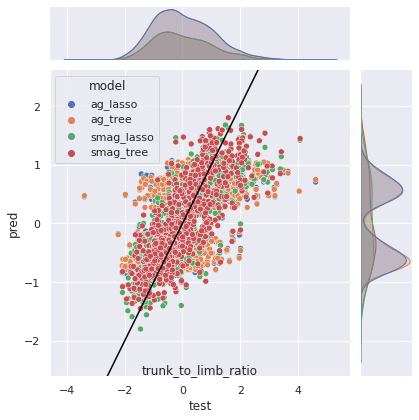

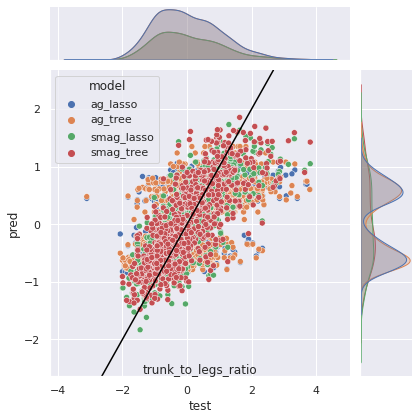

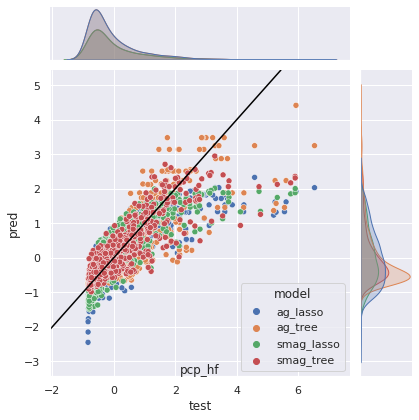

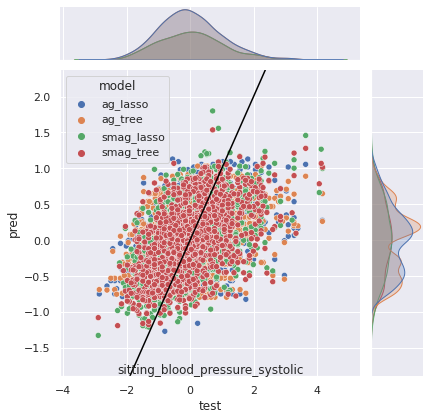

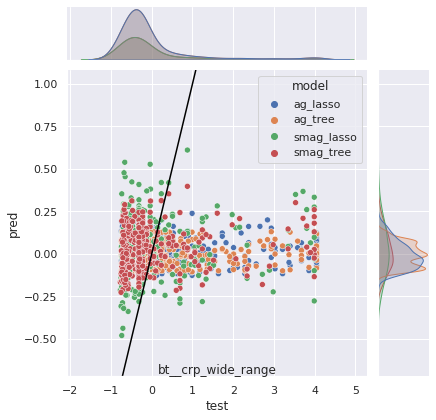

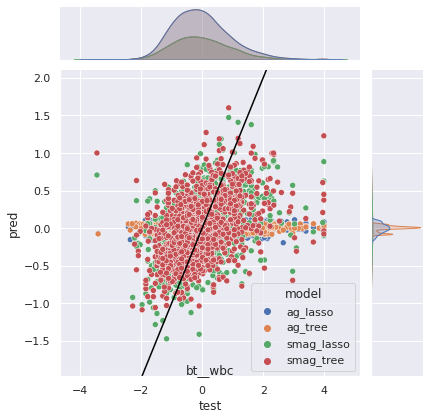

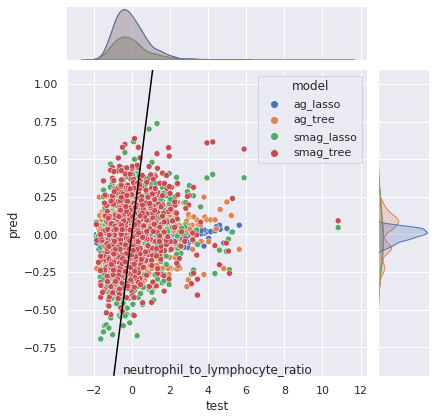

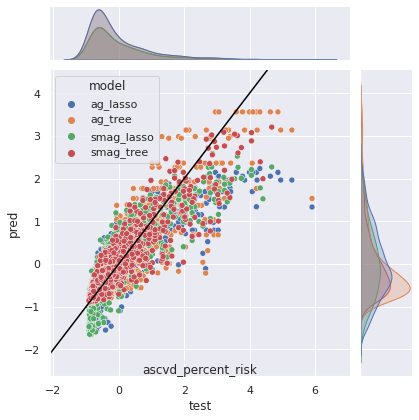

In [24]:

for rs, data in all_data.items():

    jp = sns.jointplot(data=data.replace({"model": {i: label for i, label in enumerate(model.values())}}), x='y_test', y='y_pred', hue='model')


    jp.set_axis_labels('test', 'pred')
    jp.ax_joint.axline([0, 0], [1, 1], color='black', label='Identity')
    # g.ax_joint.annotate(
    #     f'$tree_\\rho = {metrics_tree.loc[rs].pearson_r[0]:.3f}$  \n $lasso_\\rho = {metrics_lasso.loc[rs].pearson_r[0]:.3f}$',
    #     xy=(0.65, 0.25), xycoords='axes fraction',
    #     ha='left', va='center',
    #     bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
    # g.ax_joint.annotate(rs,
    #                     xy=(0.4, 0.1), xycoords='axes fraction',
    #                     ha='left', va='center')


    jp.ax_joint.set_title(rs, y=-0.01)

    jp.savefig(join(ag_smag_plot_path, 'ScatterPlots', f'{rs}_all_models_scatterplot.png'))



## Residuals Distributions

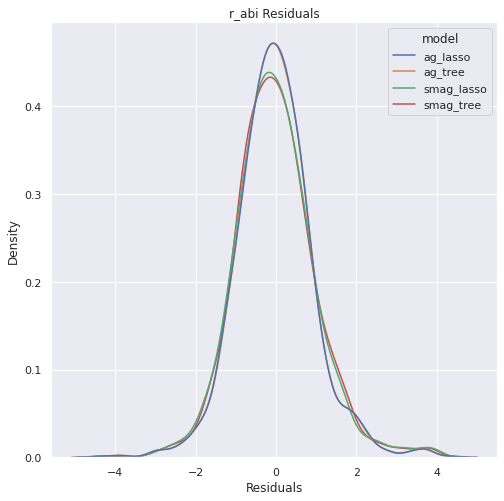

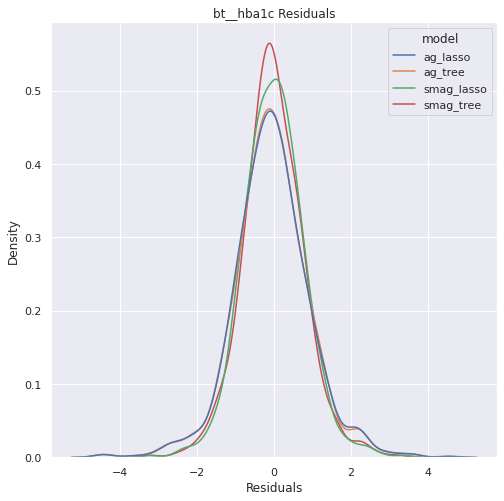

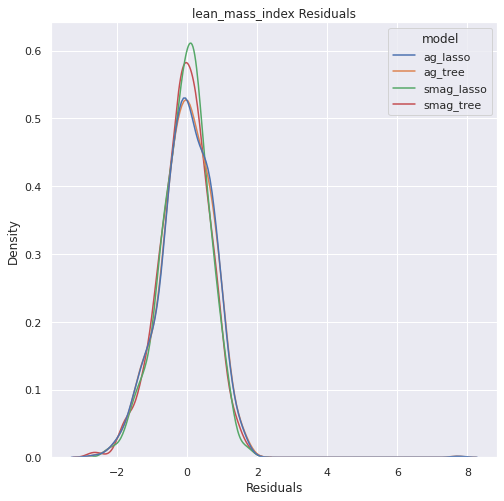

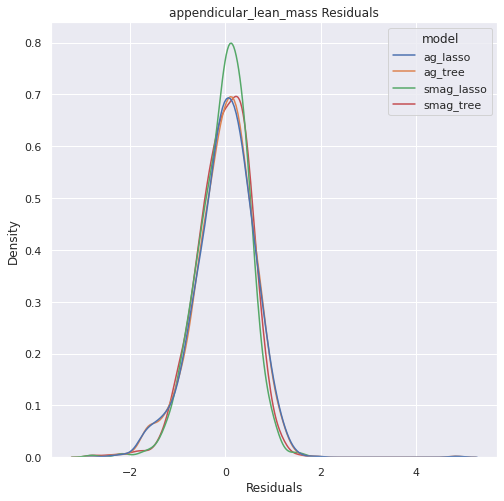

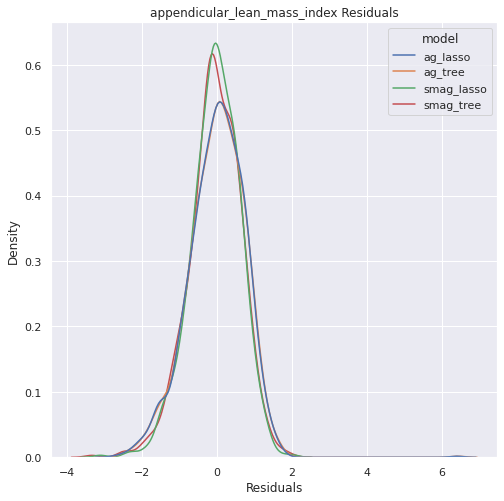

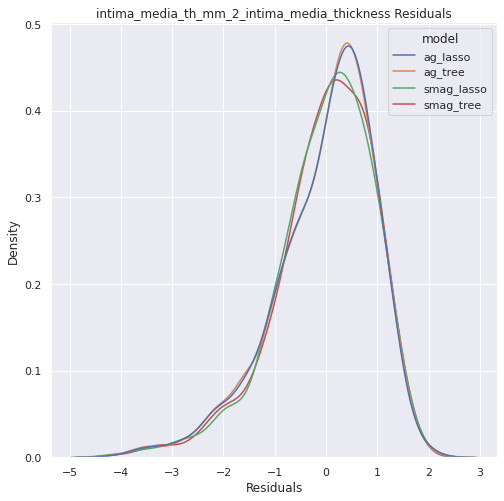

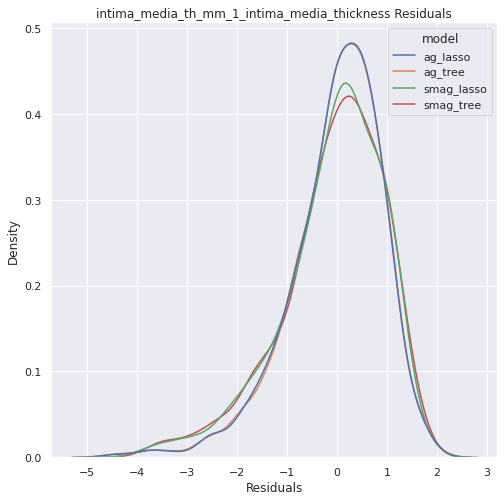

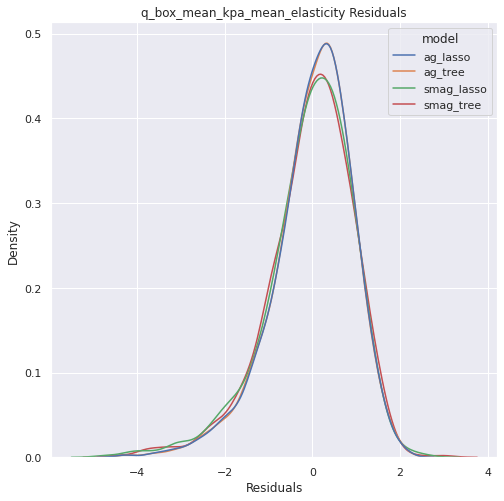

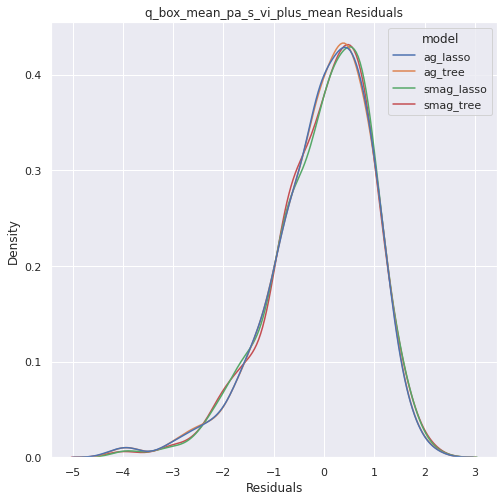

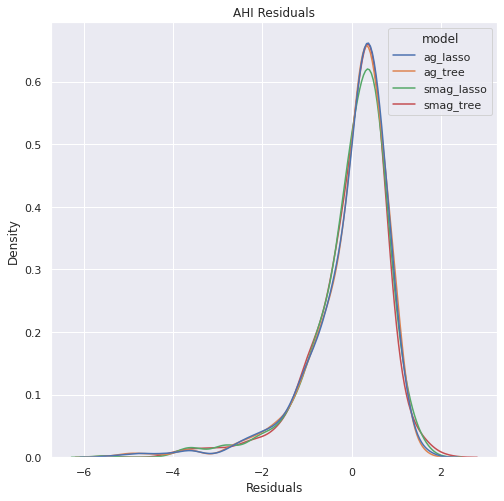

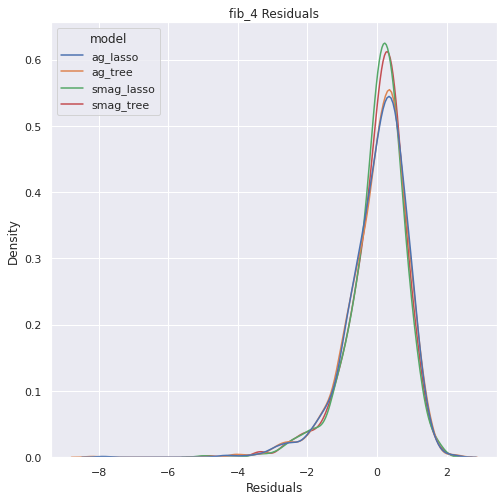

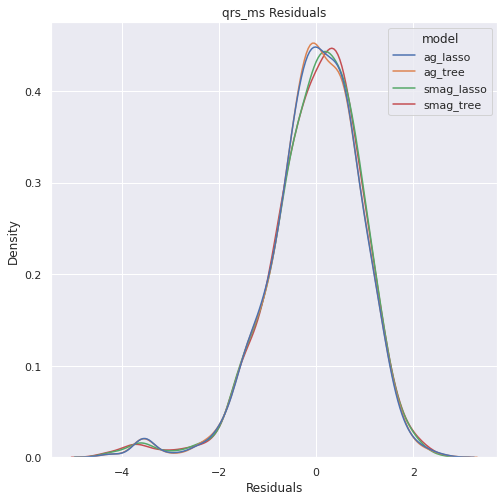

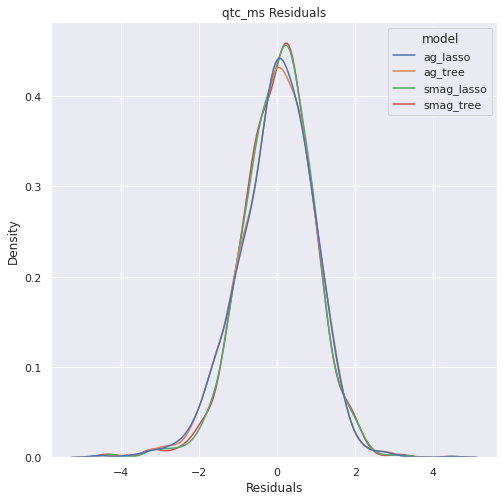

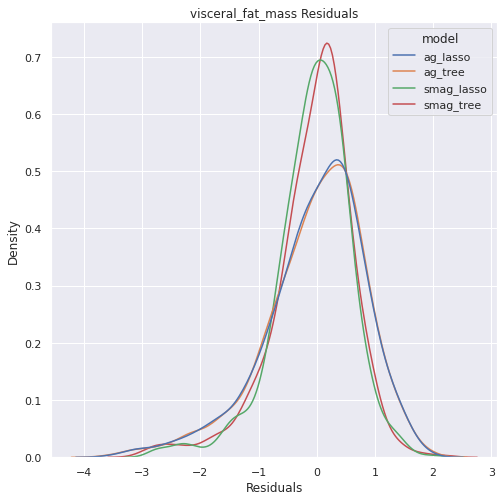

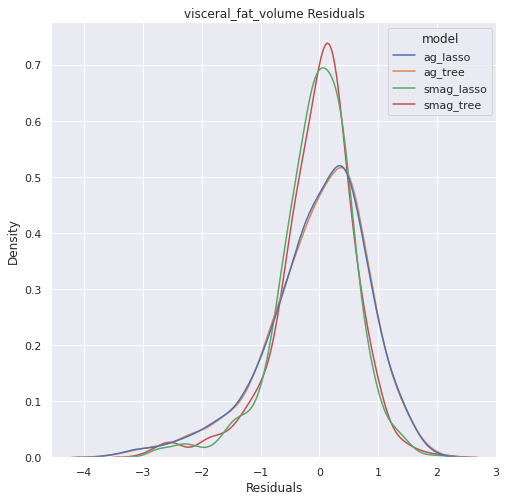

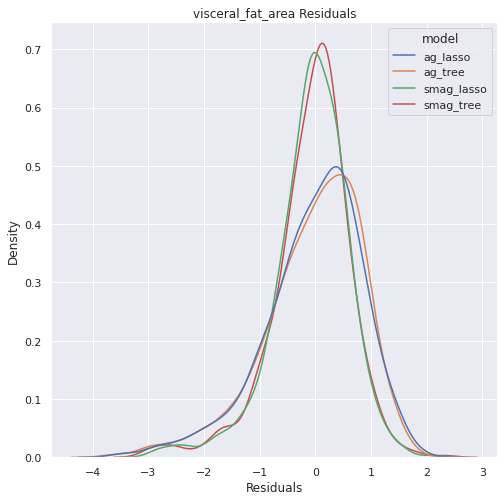

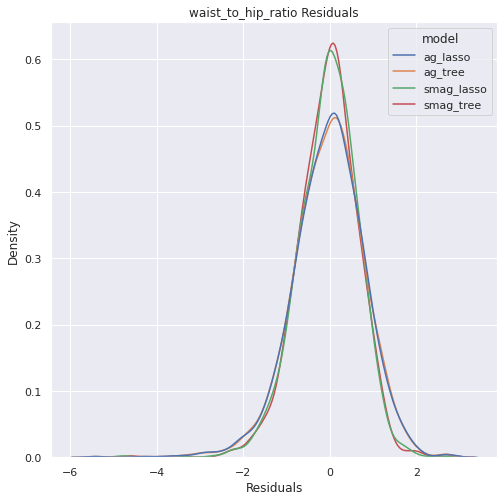

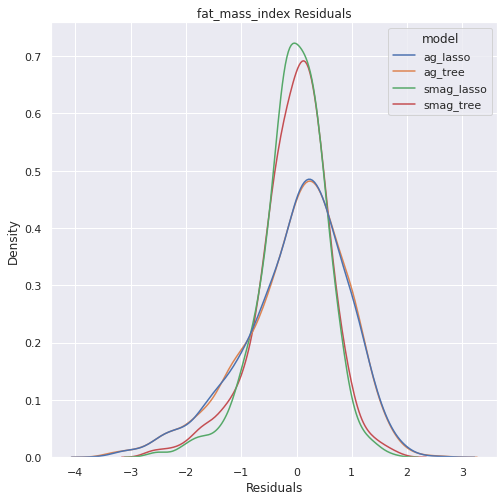

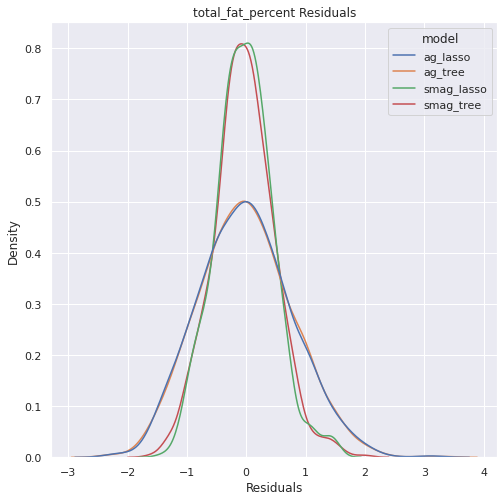

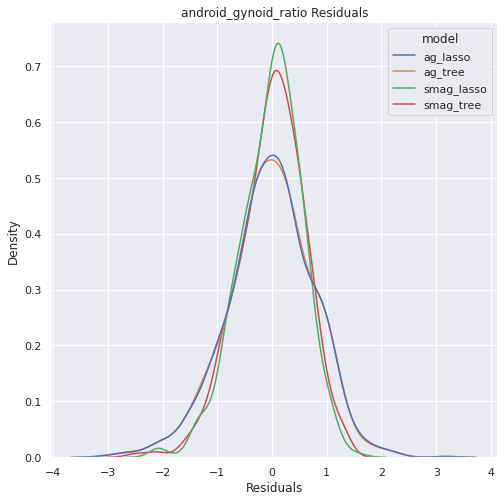

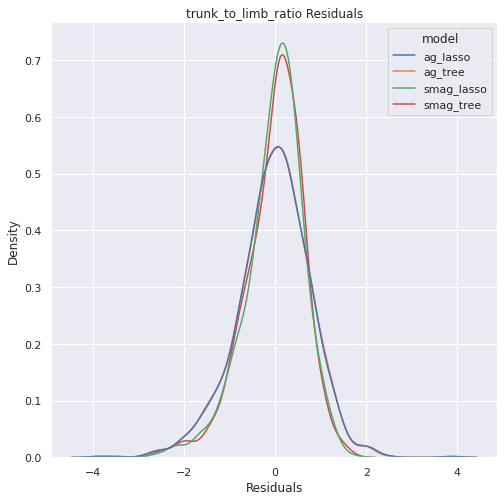

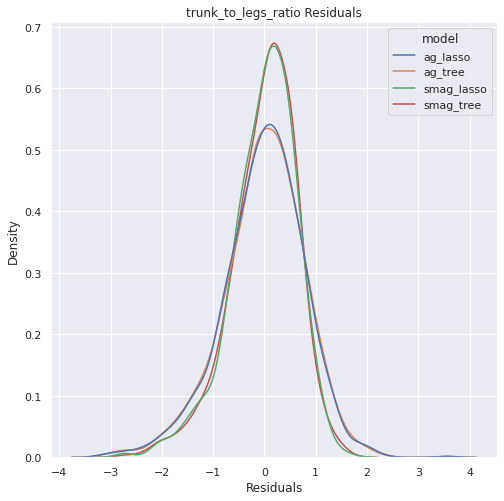

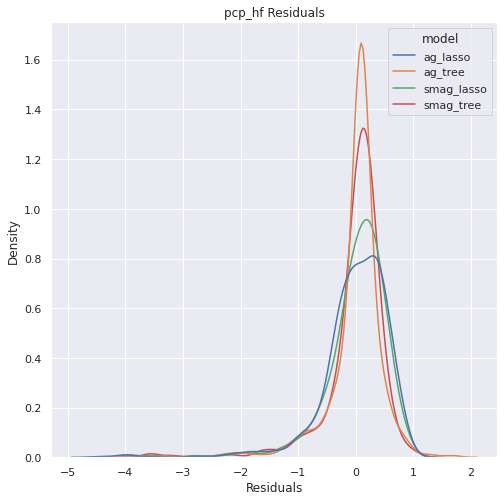

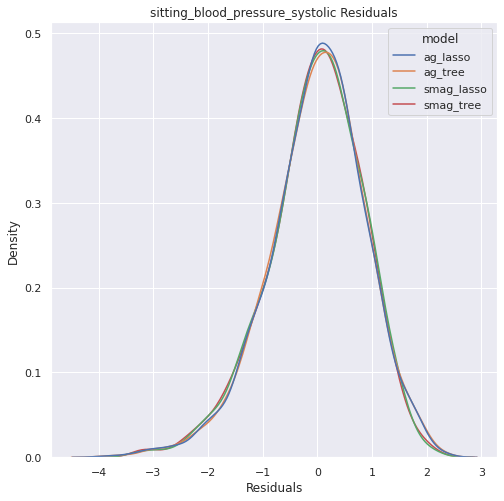

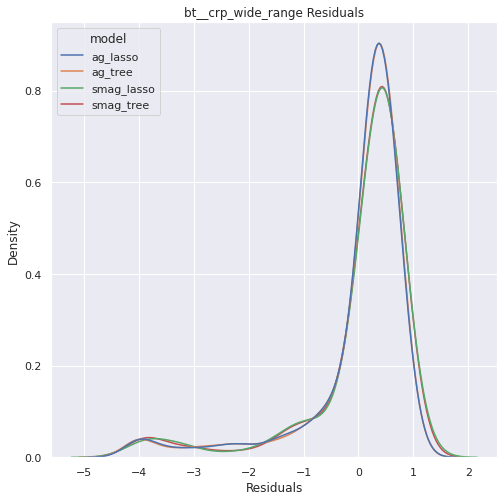

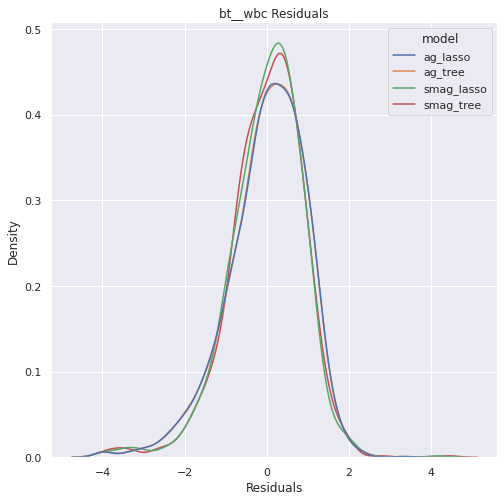

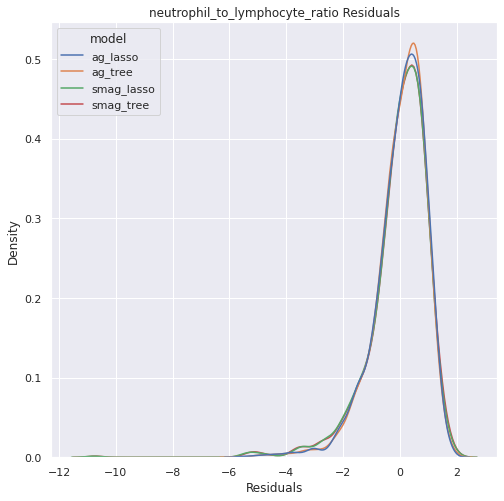

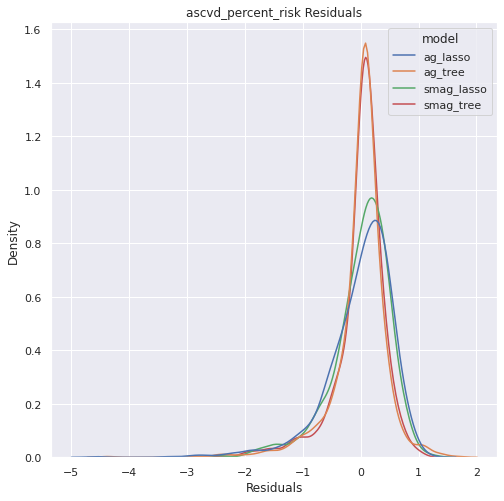

In [25]:
plt.rcParams['figure.figsize'] = [8, 8]
for rs, data in all_data.items():

    # res_plot = sns.histplot(data=data.replace({"model": {i: label for i, label in enumerate(model.values())}}), x='Residuals', hue='model', multiple='dodge', stat='probability', common_norm=False)
    res_plot = sns.kdeplot(data=data.replace({"model": {i: label for i, label in enumerate(model.values())}}), x='Residuals', hue='model', multiple='layer', common_norm=False)
    res_plot.set_title(f'{rs} Residuals')
    plt.show()

    res_plot.get_figure().savefig(join(ag_smag_plot_path, 'Residuals',f'{rs}_residuals_kdeplot.png'), bbox_inches='tight')



# SHAP

In [16]:

abs_mean_df_ag_tree = pd.DataFrame()
shap_df_ag_tree = {}

abs_mean_df_smag_tree = pd.DataFrame()
shap_df_smag_tree = {}

abs_mean_df_ag_lasso = pd.DataFrame()
shap_df_ag_lasso = {}

abs_mean_df_smag_lasso = pd.DataFrame()
shap_df_smag_lasso = {}


for rs in ag_x_test.index:
    ag_x_test_rs = ag_x_test.loc[rs]

    explainer_ag_tree = shap.explainers.Tree(ag_results.model_tree.loc[rs], ag_x_test_rs)
    shap_values_ag_tree = explainer_ag_tree.shap_values(ag_x_test_rs, check_additivity=False)

    shap_df_tmp_ag_tree = pd.DataFrame(shap_values_ag_tree, columns=ag_x_test_rs.columns, index=ag_x_test_rs.index)
    shap_df_ag_tree[rs] = shap_df_tmp_ag_tree

    abs_mean_tmp_ag_tree = shap_df_tmp_ag_tree.abs().mean(axis='index')
    abs_mean_df_ag_tree[rs] = abs_mean_tmp_ag_tree


    explainer_ag_lasso = shap.LinearExplainer(ag_results.model_lasso.loc[rs], ag_x_test_rs)
    shap_values_ag_lasso = explainer_ag_lasso.shap_values(ag_x_test_rs)
    shap_df_tmp_ag_lasso = pd.DataFrame(shap_values_ag_lasso, columns=ag_x_test_rs.columns, index=ag_x_test_rs.index)
    shap_df_ag_lasso[rs] = shap_df_tmp_ag_lasso

    abs_mean_tmp_ag_lasso = shap_df_tmp_ag_lasso.abs().mean(axis='index')
    abs_mean_df_ag_lasso[rs] = abs_mean_tmp_ag_lasso



    smag_x_test_rs = smag_x_test.loc[rs]

    explainer_smag_tree = shap.explainers.Tree(smag_results.model_tree.loc[rs], smag_x_test_rs)
    shap_values_smag_tree = explainer_smag_tree.shap_values(smag_x_test_rs, check_additivity=False)

    shap_df_tmp_smag_tree = pd.DataFrame(shap_values_smag_tree, columns=smag_x_test_rs.columns, index=smag_x_test_rs.index)
    shap_df_smag_tree[rs] = shap_df_tmp_smag_tree

    abs_mean_tmp_smag_tree = shap_df_tmp_smag_tree.abs().mean(axis='index')
    abs_mean_df_smag_tree[rs] = abs_mean_tmp_smag_tree


    explainer_smag_lasso = shap.LinearExplainer(smag_results.model_lasso.loc[rs], smag_x_test_rs)
    shap_values_smag_lasso = explainer_smag_lasso.shap_values(smag_x_test_rs)
    shap_df_tmp_smag_lasso = pd.DataFrame(shap_values_smag_lasso, columns=smag_x_test_rs.columns, index=smag_x_test_rs.index)
    shap_df_smag_lasso[rs] = shap_df_tmp_smag_lasso

    abs_mean_tmp_smag_lasso = shap_df_tmp_smag_lasso.abs().mean(axis='index')
    abs_mean_df_smag_lasso[rs] = abs_mean_tmp_smag_lasso




 99%|===================| 820/828 [00:45<00:00]          

In [319]:
ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5).T

r_abi  bt__hba1c  lean_mass_index  \
gender                                  0.176842        NaN         0.516183   
Lipids_NEG_680.6550_417.0596_296.9210   0.037546        NaN              NaN   
Lipids_NEG_804.6131_360.6417_311.3464   0.033847        NaN              NaN   
age                                     0.021396   0.133997              NaN   
Lipids_POS_959.7641_364.8096_349.9804   0.008287        NaN              NaN   
Lipids_POS_794.8619_343.7686_309.7882        NaN   0.043444              NaN   
Lipids_POS_866.6620_381.2926_326.2855        NaN   0.041986              NaN   
Lipids_POS_984.8932_496.4812_364.5430        NaN   0.041664              NaN   
Lipids_POS_719.5678_324.0620_307.7823        NaN   0.022273              NaN   
Lipids_POS_719.5687_298.7545_302.5811        NaN        NaN         0.109096   
Lipids_POS_664.6702_396.7530_299.2589        NaN        NaN         0.034897   
Lipids_POS_1009.7944_410.7369_360.1187       NaN        NaN         0.033041   
Lipids_POS_1031.6912_300.9537_347.0401       NaN        NaN         0.029413   
Lipids_POS_814.6222_355.0035_311.8197        NaN        NaN              NaN   
Lipids_POS_729.5897_333.6603_305.6820        NaN        NaN              NaN   
Lipids_POS_830.5675_310.1995_307.1010        NaN        NaN              NaN   
Lipids_POS_698.6074_385.6549_304.1780        NaN        NaN              NaN   
Lipids_POS_687.5424_301.8498_291.4130        NaN        NaN              NaN   
Lipids_POS_695.5088_291.3665_287.5858        NaN        NaN              NaN   
Lipids_POS_608.4643_296.0956_269.9884        NaN        NaN              NaN   
Lipids_POS_677.5578_317.0985_294.6911        NaN        NaN              NaN   
Lipids_POS_552.4021_243.2522_254.7229        NaN        NaN              NaN   
Lipids_POS_963.8108_433.1830_357.2509        NaN        NaN              NaN   
Lipids_POS_863.6901_424.6823_313.9536        NaN        NaN              NaN   
Lipids_POS_718.5738_357.3226_297.4026        NaN        NaN              NaN   

                                        appendicular_lean_mass  \
gender                                                0.661842   
Lipids_NEG_680.6550_417.0596_296.9210                      NaN   
Lipids_NEG_804.6131_360.6417_311.3464                      NaN   
age                                                   0.035353   
Lipids_POS_959.7641_364.8096_349.9804                      NaN   
Lipids_POS_794.8619_343.7686_309.7882                      NaN   
Lipids_POS_866.6620_381.2926_326.2855                      NaN   
Lipids_POS_984.8932_496.4812_364.5430                      NaN   
Lipids_POS_719.5678_324.0620_307.7823                      NaN   
Lipids_POS_719.5687_298.7545_302.5811                 0.065602   
Lipids_POS_664.6702_396.7530_299.2589                 0.027732   
Lipids_POS_1009.7944_410.7369_360.1187                     NaN   
Lipids_POS_1031.6912_300.9537_347.0401                0.026782   
Lipids_POS_814.6222_355.0035_311.8197                      NaN   
Lipids_POS_729.5897_333.6603_305.6820                      NaN   
Lipids_POS_830.5675_310.1995_307.1010                      NaN   
Lipids_POS_698.6074_385.6549_304.1780                      NaN   
Lipids_POS_687.5424_301.8498_291.4130                      NaN   
Lipids_POS_695.5088_291.3665_287.5858                      NaN   
Lipids_POS_608.4643_296.0956_269.9884                      NaN   
Lipids_POS_677.5578_317.0985_294.6911                      NaN   
Lipids_POS_552.4021_243.2522_254.7229                      NaN   
Lipids_POS_963.8108_433.1830_357.2509                      NaN   
Lipids_POS_863.6901_424.6823_313.9536                      NaN   
Lipids_POS_718.5738_357.3226_297.4026                      NaN   

                                        appendicular_lean_mass_index  \
gender                                                      0.545168   
Lipids_NEG_680.6550_417.0596_296.9210                            NaN   
Lipids_NEG_804.6131_360.6417_

In [320]:
pd.concat([ShapCalc.get_most_important_frequency(ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5)), ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5).T], axis=1)

0     r_abi  bt__hba1c  \
gender                                  15  0.176842        NaN   
Lipids_NEG_680.6550_417.0596_296.9210    1  0.037546        NaN   
Lipids_NEG_804.6131_360.6417_311.3464    1  0.033847        NaN   
age                                     12  0.021396   0.133997   
Lipids_POS_959.7641_364.8096_349.9804    1  0.008287        NaN   
Lipids_POS_794.8619_343.7686_309.7882    1       NaN   0.043444   
Lipids_POS_866.6620_381.2926_326.2855    1       NaN   0.041986   
Lipids_POS_984.8932_496.4812_364.5430    1       NaN   0.041664   
Lipids_POS_719.5678_324.0620_307.7823    1       NaN   0.022273   
Lipids_POS_719.5687_298.7545_302.5811    5       NaN        NaN   
Lipids_POS_664.6702_396.7530_299.2589    4       NaN        NaN   
Lipids_POS_1009.7944_410.7369_360.1187   2       NaN        NaN   
Lipids_POS_1031.6912_300.9537_347.0401   4       NaN        NaN   
Lipids_POS_814.6222_355.0035_311.8197    3       NaN        NaN   
Lipids_POS_729.5897_333.6603_305.6820    1       NaN        NaN   
Lipids_POS_830.5675_310.1995_307.1010    4       NaN        NaN   
Lipids_POS_698.6074_385.6549_304.1780    1       NaN        NaN   
Lipids_POS_687.5424_301.8498_291.4130    2       NaN        NaN   
Lipids_POS_695.5088_291.3665_287.5858    2       NaN        NaN   
Lipids_POS_608.4643_296.0956_269.9884    1       NaN        NaN   
Lipids_POS_677.5578_317.0985_294.6911    2       NaN        NaN   
Lipids_POS_552.4021_243.2522_254.7229    1       NaN        NaN   
Lipids_POS_963.8108_433.1830_357.2509    2       NaN        NaN   
Lipids_POS_863.6901_424.6823_313.9536    2       NaN        NaN   
Lipids_POS_718.5738_357.3226_297.4026    1       NaN        NaN   

                                        lean_mass_index  \
gender                                         0.516183   
Lipids_NEG_680.6550_417.0596_296.9210               NaN   
Lipids_NEG_804.6131_360.6417_311.3464               NaN   
age                                                 NaN   
Lipids_POS_959.7641_364.8096_349.9804               NaN   
Lipids_POS_794.8619_343.7686_309.7882               NaN   
Lipids_POS_866.6620_381.2926_326.2855               NaN   
Lipids_POS_984.8932_496.4812_364.5430               NaN   
Lipids_POS_719.5678_324.0620_307.7823               NaN   
Lipids_POS_719.5687_298.7545_302.5811          0.109096   
Lipids_POS_664.6702_396.7530_299.2589          0.034897   
Lipids_POS_1009.7944_410.7369_360.1187         0.033041   
Lipids_POS_1031.6912_300.9537_347.0401         0.029413   
Lipids_POS_814.6222_355.0035_311.8197               NaN   
Lipids_POS_729.5897_333.6603_305.6820               NaN   
Lipids_POS_830.5675_310.1995_307.1010               NaN   
Lipids_POS_698.6074_385.6549_304.1780               NaN   
Lipids_POS_687.5424_301.8498_291.4130               NaN   
Lipids_POS_695.5088_291.3665_287.5858               NaN   
Lipids_POS_608.4643_296.0956_269.9884               NaN   
Lipids_POS_677.5578_317.0985_294.6911               NaN   
Lipids_POS_552.4021_243.2522_254.7229               NaN   
Lipids_POS_963.8108_433.1830_357.2509               NaN   
Lipids_POS_863.6901_424.6823_313.9536               NaN   
Lipids_POS_718.5738_357.3226_297.4026               NaN   

                                        appendicular_lean_mass  \
gender                                                0.661842   
Lipids_NEG_680.6550_417.0596_296.9210                      NaN   
Lipids_NEG_804.6131_360.6417_311.3464                      NaN   
age                                                   0.035353   
Lipids_POS_959.7641_364.8096_349.9804                      NaN   
Lipids_POS_794.8619_343.7686_309.7882                      NaN   
Lipids_POS_866.6620_381.2926_326.2855                      NaN   
Lipids_POS_984.8932_496.4812_364.5430                      NaN   
Lipids_POS_719.5678_324.0620_307.7823                      NaN   
Lipids_POS_719.5687_298.7545_302.5811                 0.065602   
Lipids_POS_664.6702_396.7530_299.2589

In [32]:
plt.rcParams['figure.figsize'] = [15, 15]

Text(0.5, 1.0, 'The 5 most impactful features')

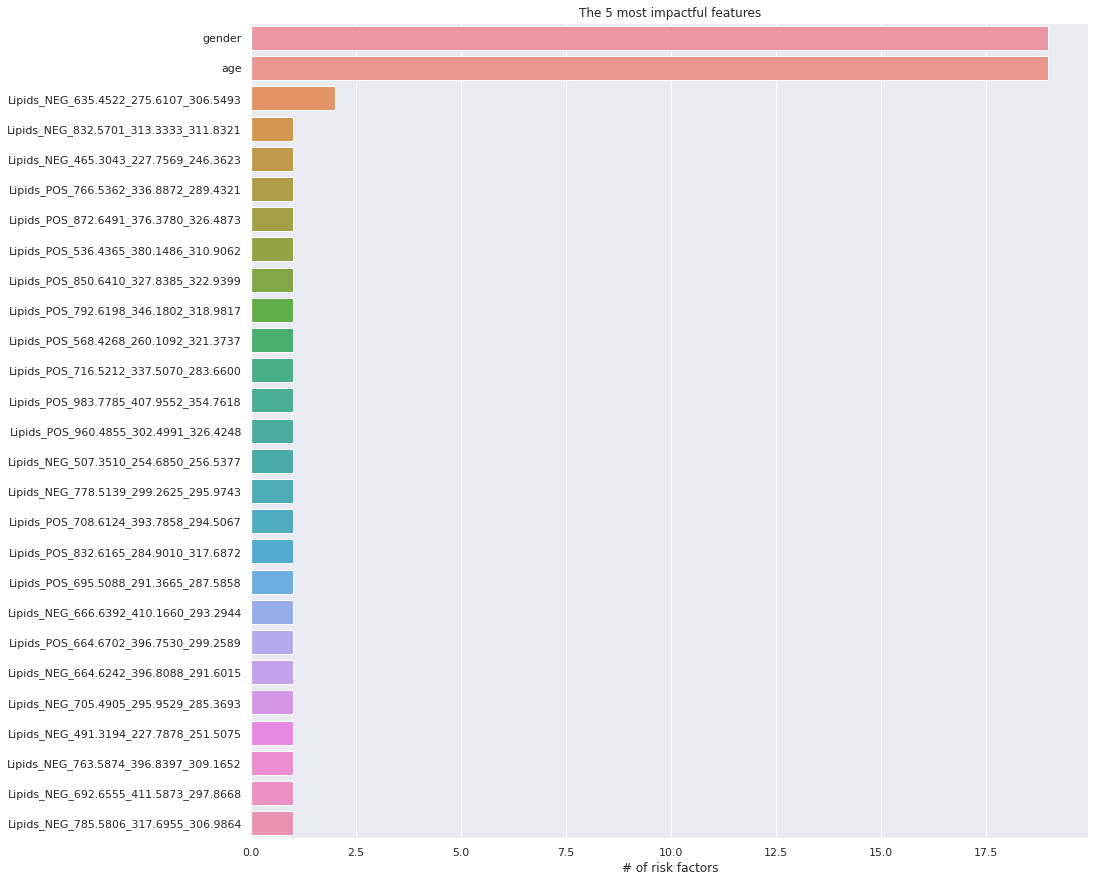

In [17]:
sns.barplot(x=ShapCalc.get_most_important_frequency(ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5)).sort_values(ascending=False), y=ShapCalc.get_most_important_frequency(ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5)).sort_values(ascending=False).index)
plt.xlabel('# of risk factors')
plt.title('The 5 most impactful features')

Text(0.5, 1.0, 'The 5 most impactful features')

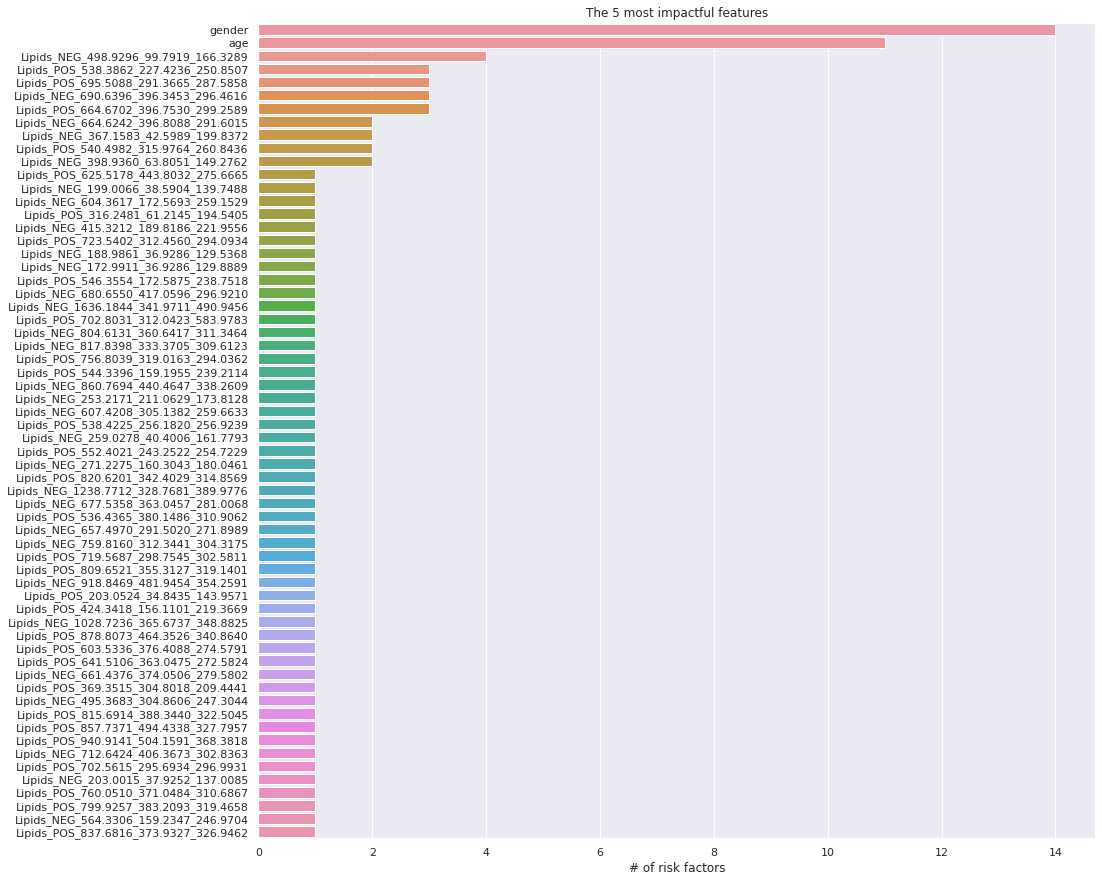

In [18]:
sns.barplot(x=ShapCalc.get_most_important_frequency(ShapCalc.get_n_important_features(abs_mean_df_smag_tree.T, n=5)).sort_values(ascending=False), y=ShapCalc.get_most_important_frequency(ShapCalc.get_n_important_features(abs_mean_df_smag_tree.T, n=5)).sort_values(ascending=False).index)
plt.xlabel('# of risk factors')
plt.title('The 5 most impactful features')

In [356]:
# sns.heatmap(ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5).T.combine_first(abs_mean_df_smag_lasso).loc[ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5).T.index])
abs_mean_df_smag_lasso
ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5)

gender  \
r_abi                            0.176842   
bt__hba1c                             NaN   
lean_mass_index                  0.516183   
appendicular_lean_mass           0.661842   
appendicular_lean_mass_index     0.545168   
AHI                              0.113931   
visceral_fat_mass                0.322347   
visceral_fat_volume              0.325677   
visceral_fat_area                0.272748   
waist_to_hip_ratio               0.378677   
fat_mass_index                   0.156607   
total_fat_percent                0.371011   
android_gynoid_ratio             0.433185   
trunk_to_limb_ratio              0.420488   
trunk_to_legs_ratio              0.405385   
sitting_blood_pressure_systolic  0.261938   

                                 Lipids_NEG_680.6550_417.0596_296.9210  \
r_abi                                                         0.037546   
bt__hba1c                                                          NaN   
lean_mass_index                                                    NaN   
appendicular_lean_mass                                             NaN   
appendicular_lean_mass_index                                       NaN   
AHI                                                                NaN   
visceral_fat_mass                                                  NaN   
visceral_fat_volume                                                NaN   
visceral_fat_area                                                  NaN   
waist_to_hip_ratio                                                 NaN   
fat_mass_index                                                     NaN   
total_fat_percent                                                  NaN   
android_gynoid_ratio                                               NaN   
trunk_to_limb_ratio                                                NaN   
trunk_to_legs_ratio                                                NaN   
sitting_blood_pressure_systolic                                    NaN   

                                 Lipids_NEG_804.6131_360.6417_311.3464  \
r_abi                                                         0.033847   
bt__hba1c                                                          NaN   
lean_mass_index                                                    NaN   
appendicular_lean_mass                                             NaN   
appendicular_lean_mass_index                                       NaN   
AHI                                                                NaN   
visceral_fat_mass                                                  NaN   
visceral_fat_volume                                                NaN   
visceral_fat_area                                                  NaN   
waist_to_hip_ratio                                                 NaN   
fat_mass_index                                                     NaN   
total_fat_percent                                                  NaN   
android_gynoid_ratio                                               NaN   
trunk_to_limb_ratio                                                NaN   
trunk_to_legs_ratio                                                NaN   
sitting_blood_pressure_systolic                                    NaN   

                                      age  \
r_abi                            0.021396   
bt__hba1c                        0.133997   
lean_mass_index                       NaN   
appendicular_lean_mass           0.035353   
appendicular_lean_mass_index          NaN   
AHI                              0.156659   
visceral_fat_mass                0.107911   
visceral_fat_volume              0.108313   
visceral_fat_area                0.126787   
waist_to_hip_ratio               0.149675   
fat_mass_index                        NaN   
total_fat_percent                     NaN   
android_gynoid_ratio             0.117718   
trunk_to_limb_ratio              0.085299   
trunk_to_legs_ratio              0.077937   
sitting_blood_pressure_systolic

In [357]:
ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5).fillna(abs_mean_df_smag_lasso.T.fillna(0))

gender  \
r_abi                            0.176842   
bt__hba1c                        0.001706   
lean_mass_index                  0.516183   
appendicular_lean_mass           0.661842   
appendicular_lean_mass_index     0.545168   
AHI                              0.113931   
visceral_fat_mass                0.322347   
visceral_fat_volume              0.325677   
visceral_fat_area                0.272748   
waist_to_hip_ratio               0.378677   
fat_mass_index                   0.156607   
total_fat_percent                0.371011   
android_gynoid_ratio             0.433185   
trunk_to_limb_ratio              0.420488   
trunk_to_legs_ratio              0.405385   
sitting_blood_pressure_systolic  0.261938   

                                 Lipids_NEG_680.6550_417.0596_296.9210  \
r_abi                                                         0.037546   
bt__hba1c                                                     0.000000   
lean_mass_index                                               0.000000   
appendicular_lean_mass                                        0.000000   
appendicular_lean_mass_index                                  0.000000   
AHI                                                           0.000000   
visceral_fat_mass                                             0.000000   
visceral_fat_volume                                           0.000000   
visceral_fat_area                                             0.000000   
waist_to_hip_ratio                                            0.000000   
fat_mass_index                                                0.000000   
total_fat_percent                                             0.000000   
android_gynoid_ratio                                          0.000000   
trunk_to_limb_ratio                                           0.000000   
trunk_to_legs_ratio                                           0.000000   
sitting_blood_pressure_systolic                               0.000000   

                                 Lipids_NEG_804.6131_360.6417_311.3464  \
r_abi                                                         0.033847   
bt__hba1c                                                     0.000000   
lean_mass_index                                               0.000000   
appendicular_lean_mass                                        0.000000   
appendicular_lean_mass_index                                  0.000000   
AHI                                                           0.000000   
visceral_fat_mass                                             0.000000   
visceral_fat_volume                                           0.000000   
visceral_fat_area                                             0.000000   
waist_to_hip_ratio                                            0.000000   
fat_mass_index                                                0.000000   
total_fat_percent                                             0.000000   
android_gynoid_ratio                                          0.000000   
trunk_to_limb_ratio                                           0.000000   
trunk_to_legs_ratio                                           0.000000   
sitting_blood_pressure_systolic                               0.000000   

                                      age  \
r_abi                            0.021396   
bt__hba1c                        0.133997   
lean_mass_index                  0.000000   
appendicular_lean_mass           0.035353   
appendicular_lean_mass_index     0.010555   
AHI                              0.156659   
visceral_fat_mass                0.107911   
visceral_fat_volume              0.108313   
visceral_fat_area                0.126787   
waist_to_hip_ratio               0.149675   
fat_mass_index                   0.000000   
total_fat_percent                0.003795   
android_gynoid_ratio             0.117718   
trunk_to_limb_ratio              0.085299   
trunk_to_legs_ratio              0.077937   
sitting_blood_pressure_systolic

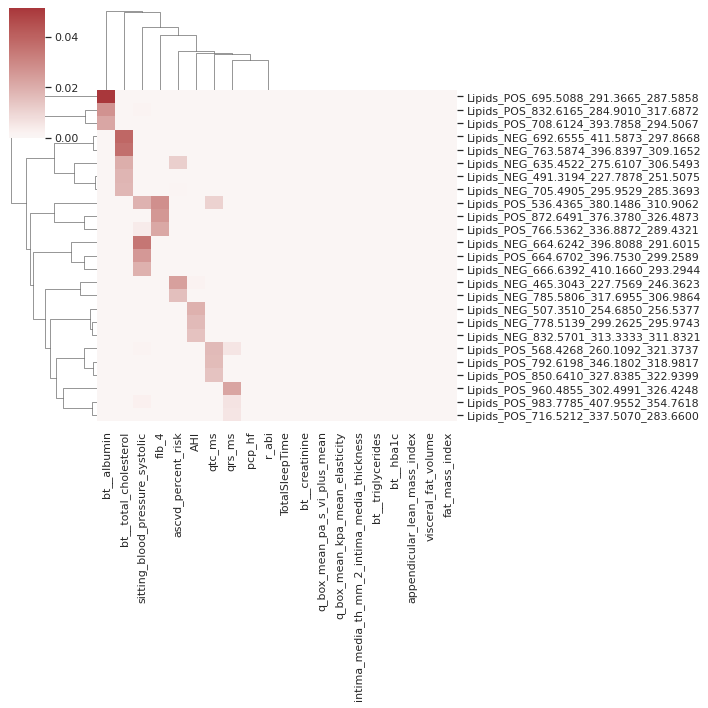

In [19]:
sns.clustermap(ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5).fillna(abs_mean_df_smag_lasso.T.fillna(0)).T.drop(['gender', 'age']), cmap="vlag", center=0, robust=False)

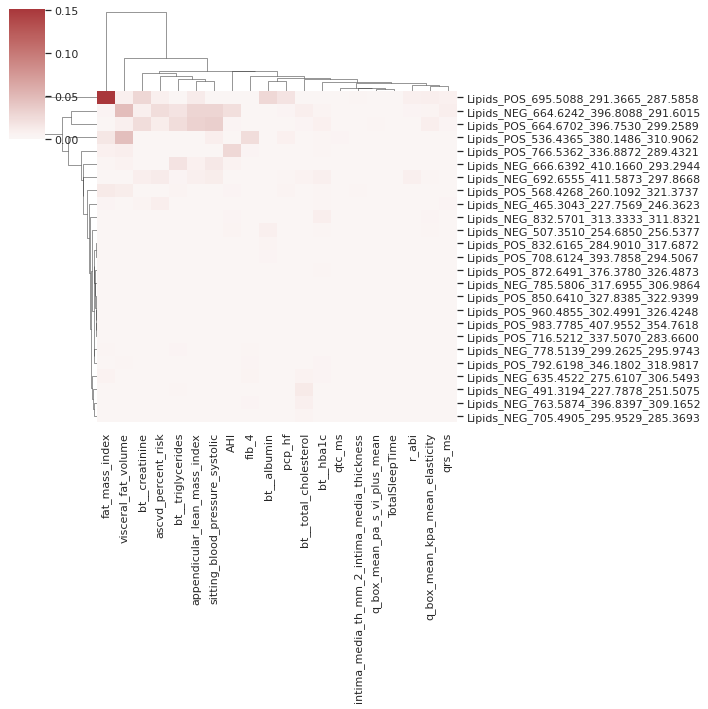

In [20]:
sns.clustermap(abs_mean_df_smag_tree.loc[ShapCalc.get_n_important_features(abs_mean_df_smag_lasso.T, n=5).fillna(abs_mean_df_smag_lasso.T.fillna(0)).T.drop(['gender', 'age']).index], cmap="vlag", center=0, robust=False)

In [255]:
pd.concat(shap_df_smag_tree)

age    gender  \
                    RegistrationCode                       
lean_mass_index     10K_3325004044   -0.000249 -0.280686   
                    10K_2429969750    0.000134 -0.289737   
                    10K_9092918744    0.000076 -0.254736   
                    10K_1020576262    0.000091 -0.310280   
                    10K_3760818231    0.000109  0.332538   
...                                        ...       ...   
trunk_to_legs_ratio 10K_2199234560    0.046953  0.239441   
                    10K_6149521575   -0.013273  0.233687   
                    10K_3562152860   -0.004055 -0.161783   
                    10K_7595120920    0.050106  0.227314   
                    10K_4194601557   -0.005255 -0.181607   

                                      Lipids_NEG_213.0551_31.1470_150.8722  \
                    RegistrationCode                                         
lean_mass_index     10K_3325004044                               -0.000289   
                    10K_2429969750                                0.001627   
                    10K_9092918744                                0.002041   
                    10K_1020576262                                0.001171   
                    10K_3760818231                                0.000092   
...                                                                    ...   
trunk_to_legs_ratio 10K_2199234560                                0.000494   
                    10K_6149521575                                0.000943   
                    10K_3562152860                                0.000707   
                    10K_7595120920                               -0.000788   
                    10K_4194601557                                0.000200   

                                      Lipids_NEG_217.0025_30.9563_142.6050  \
                    RegistrationCode                                         
lean_mass_index     10K_3325004044                                0.000066   
                    10K_2429969750                               -0.001776   
                    10K_9092918744                                0.000009   
                    10K_1020576262                                0.000142   
                    10K_3760818231                               -0.000193   
...                                                                    ...   
trunk_to_legs_ratio 10K_2199234560                               -0.000137   
                    10K_6149521575                               -0.000818   
                    10K_3562152860                                0.000030   
                    10K_7595120920                               -0.000222   
                    10K_4194601557                               -0.000098   

                                      Lipids_NEG_232.9752_30.7462_142.0463  \
                    RegistrationCode                                         
lean_mass_index     10K_3325004044                               -0.000058   
                    10K_2429969750                               -0.000038   
                    10K_9092918744                               -0.000127   
                    10K_1020576262                               -0.000010   
                    10K_3760818231                                0.000143   
...                                                                    ...   
trunk_to_legs_ratio 10K_2199234560                               -0.000040   
                    10K_6149521575                               -0.000163   
                    10K_3562152860                                0.000192   
                    10K_7595120920                               -0.000067   
                    10K_4194601557                               -0.000027   

                                      Lipids_NEG_194.9054_31.5023_122.7051  \
                    RegistrationCode                                         
lean_mass_index     10K_3325004044                           

## ScreePlot

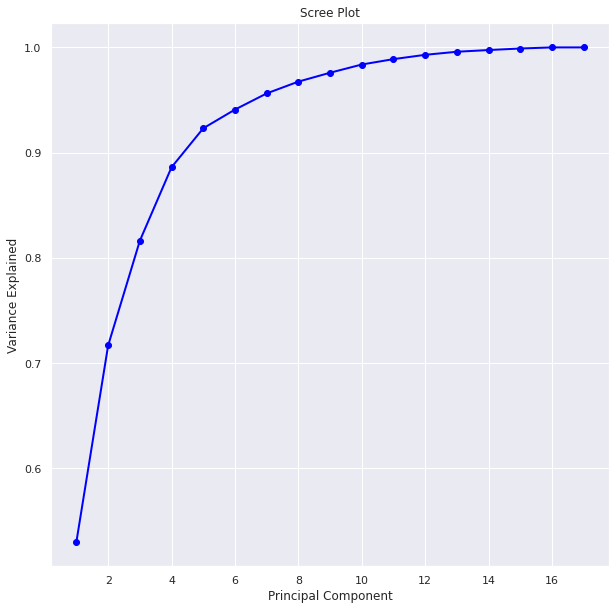

In [458]:
plt.rcParams['figure.figsize'] = [10, 10]
clustering_data = abs_mean_df_smag_tree.T  #pd.concat(shap_df_smag_tree)#abs_mean_df_smag_tree.T  #.drop(columns=['gender','age'])

pca = PCA(n_components=min(clustering_data.shape))
pca_fit = pca.fit(clustering_data)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


## Clustering and dim-reduction with umap & tsne


The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


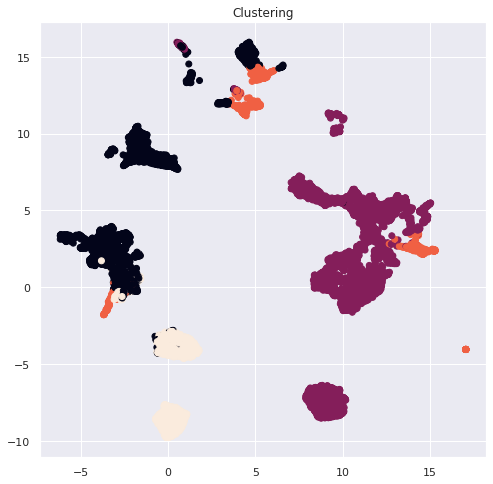

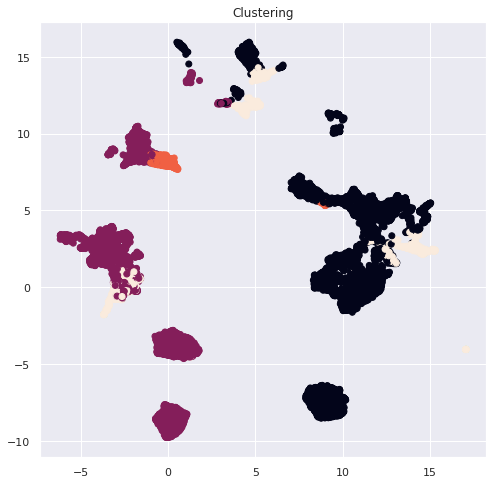

In [452]:

n_components = 128
n_clusters = 4

clusters = []
clusters.append(KMeans(n_clusters=n_clusters).fit(pca_fit.transform(clustering_data)[:, :n_components]))
clusters.append(SpectralClustering(n_clusters=n_clusters).fit(pca_fit.transform(clustering_data)[:, :n_components]))
shap_2d = UMAP(n_components=2).fit_transform((pca_fit.transform(clustering_data)[:, :n_components]))
tsne = TSNE(n_components=2).fit_transform((pca_fit.transform(clustering_data)[:, :n_components]))
for i in range(len(clusters)):
    plt.scatter(shap_2d[:, 0], shap_2d[:, 1], c=clusters[i].labels_)
    plt.title('Clustering')
    plt.show()

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


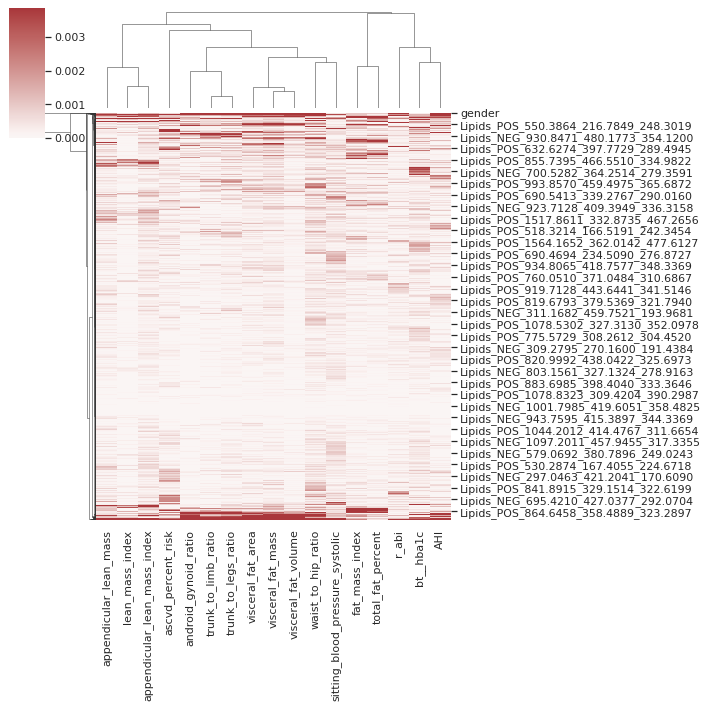

In [454]:
plt.rcParams['figure.figsize'] = [15, 15]

sns.clustermap(abs_mean_df_smag_tree, robust=True, cmap="vlag", center=0)

In [113]:
tmp = cl.load_pickle(join(ag_pred_path, 'combined_results.pickle'))

In [120]:
tmp.loc['r_abi'].metrics_tree

r_abi    {'Coefficient_of_determination': 0.07626061410...
r_abi    {'Coefficient_of_determination': 0.05656952797...
Name: metrics_tree, dtype: object